In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

cmap = mpl.cm.jet

In [58]:
PATH = "electromigration_18/ET7_spectrum_set2_"
N_RANGE = (1, 62)
file_list = lambda nrange : [PATH + '{0:03}.dat'.format(i) for i in range(*nrange)]

In [59]:
def file2df(file):
    with open(file,'r') as f:
        for i in range(70): # 70 for .dat, 8 for transport__.dat
            f.readline()
        df = pd.read_table(f)
        df = df.rename(columns={"Bias calc (V)": "V", "LI Y [AVG] (V)": "LIY"})
        return df
df = file2df(file_list(N_RANGE)[0])
df.head()

V  Current [AVG] (A)  LI X [AVG] (V)       LIY  Current [00001] (A)  \
0  1.000000       1.009580e-10        0.251308  0.484827         1.007950e-10   
1  0.996086       9.848730e-11        0.265428  0.483695         9.804040e-11   
2  0.992172       9.887980e-11        0.253561  0.472615         9.933840e-11   
3  0.988258       9.627490e-11        0.269731  0.480049         9.524440e-11   
4  0.984344       9.672140e-11        0.261123  0.465011         9.812950e-11   

   LI X [00001] (V)  LI Y [00001] (V)  Current [00002] (A)  LI X [00002] (V)  \
0          0.250833          0.486884         9.601840e-11          0.253096   
1          0.264532          0.489564         1.038210e-10          0.262721   
2          0.251185          0.474898         9.445030e-11          0.250850   
3          0.270036          0.484309         1.005370e-10          0.265032   
4          0.262248          0.457491         9.322600e-11          0.263986   

   LI Y [00002] (V)  Current [00003] (A)  LI X [00003] (V)  LI Y [00003] (V)  
0          0.480604         1.060620e-10          0.249994          0.486993  
1          0.485512         9.360110e-11          0.269032          0.476011  
2          0.468415         1.028510e-10          0.258649          0.474533  
3          0.481428         9.304330e-11          0.274125          0.474409  
4          0.460563         9.880870e-11          0.257135          0.476979

In [60]:
from scipy.signal import fftconvolve, gaussian
def find_min_deriv(df, guess=0.3, sig=5, phon_correct=False):
    smoothed = fftconvolve(df.LIY, gaussian(50, std=8), mode='same')
    deriv = fftconvolve(smoothed, [-1, 0, 1], mode='same')

In [85]:
def find_min(df, guess=0.3, sig=5, dist=10, min_prom=0.7e-2, phon_correct=True, filenum=0):
    a = fftconvolve(df.LIY, gaussian(50, std=sig), mode='same')
    peaks, _ = signal.find_peaks(-a, prominence=(min_prom, None), distance=dist)
    plt.figure()
    plt.plot(df.V, df.LIY)
    for p in peaks:
        plt.axvline(x=df.V[p])
    m = min(df.V[peaks], key=lambda x:abs(x-guess))
    plt.axvline(x=m, color='r')
    plt.title("{}".format(filenum))
    return m
#     tmp = df[np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]]
#     m = tmp.iloc[(tmp['V']-guess).abs().argsort()[:1]].V.values[0]
#     plt.figure()
#     plt.plot(df.V, a)
#     plt.axvline(m)
#     if m < 0 and phon_correct:
#         return m + 0.06
#     else:
#         return m - 0.06

-0.034986803988833554

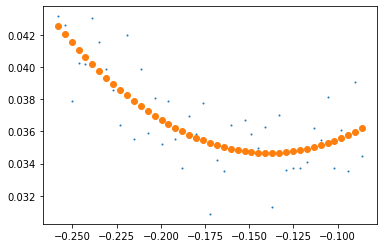

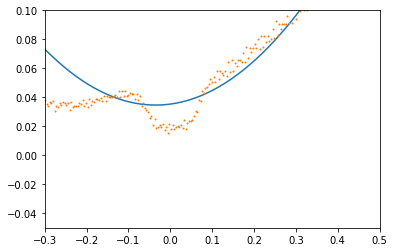

In [62]:
from scipy.optimize import curve_fit

def fit_dirac(df, crop=(-0.1, 0.1), fit_window=(-0.09, 0.09), right=True, fname=None):
    """
    Fits diract point using 4 step process
    1.) crop out phonon gap (set by crop parameter) and merge at center of crop
    2.) fit data to parabola on fit_interval
    3.) add back shift from data crop
    4.) subtract out real phonon gap (0.06V)
    
    Plots fits vs. real data as side effect
    """
    
    V_left = df[df.V < crop[0]].V
    V_right = df[df.V > crop[1]].V
    LIY_left = df[df.V < crop[0]].LIY
    LIY_right = df[df.V > crop[1]].LIY
    if right:
        V_left = V_left - np.max(V_left)
        crop_shift = np.min(V_right)
        V_right = V_right - crop_shift
    else:
        crop_shift = np.max(V_left)
        V_left = V_left - crop_shift
        V_right = V_right - np.min(V_right)
    V_cropped = pd.concat([V_left, V_right])
    LIY_cropped = pd.concat([LIY_left, LIY_right])
    LIY_cropped = LIY_cropped
    V_cropped = V_cropped[~LIY_cropped.isna()]
    LIY_cropped = LIY_cropped[~LIY_cropped.isna()]
    V_min = V_cropped.loc[LIY_cropped.idxmin()]
    fit_interval = (V_cropped < V_min + fit_window[1]) & (V_cropped > V_min + fit_window[0])
    V_fit, LIY_fit = V_cropped[fit_interval], LIY_cropped[fit_interval]
    plt.figure()
    if fname:
        plt.title(fname)
    plt.plot(V_fit, LIY_fit, 'o', markersize=1)
    fit_parms = np.polyfit(V_fit, LIY_fit, 2)
    a, b, c = fit_parms
    h = -b / (2 * a)
    k = c - b**2 / (4 * a)
    plt.plot(V_fit, a * (V_fit - h) ** 2 + k, 'o')
    h += crop_shift
    plt.figure()
    plt.plot(df.V, a * (df.V - h) ** 2 + k)
    plt.plot(df.V, df.LIY, 'o', markersize=1)
    plt.xlim(-0.3, 0.5)
    plt.ylim(-0.05, 0.1)
#     if right:
#         return h - 0.06
#     else:
#         return h + 0.06
    return h
fit_dirac(df)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


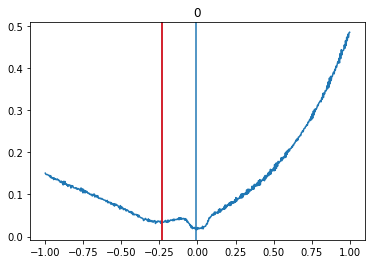

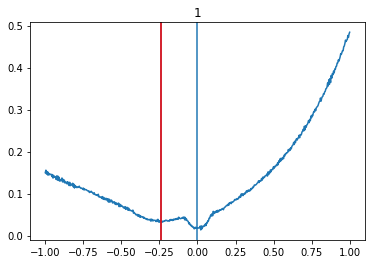

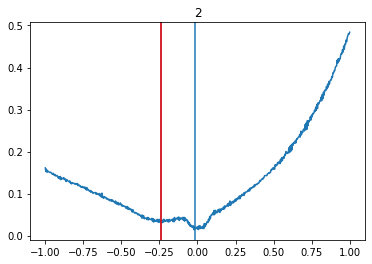

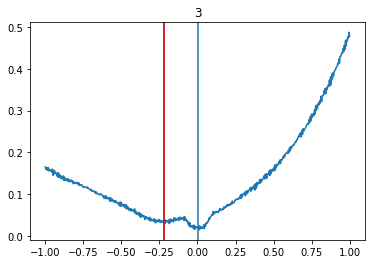

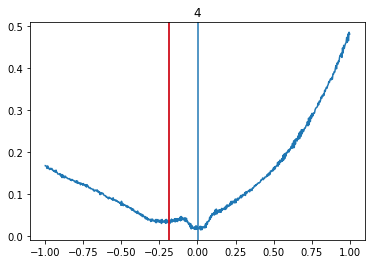

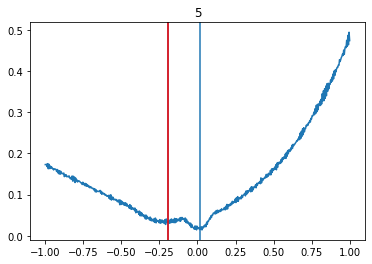

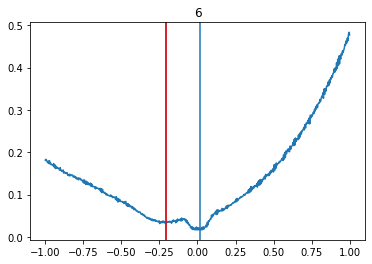

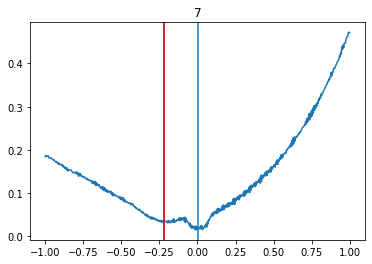

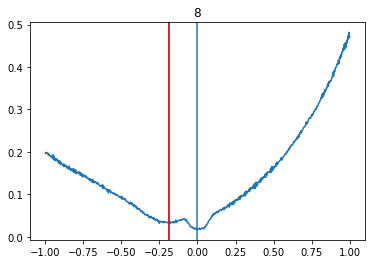

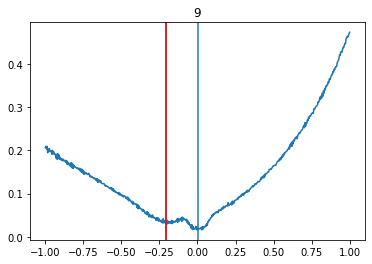

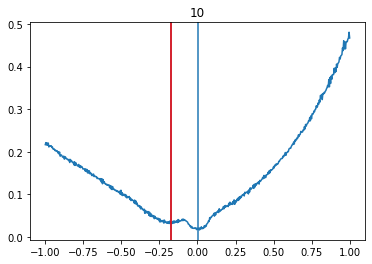

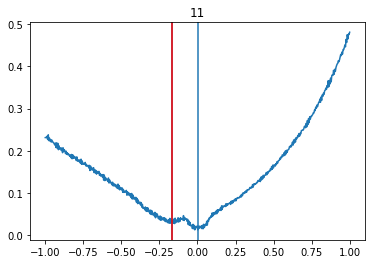

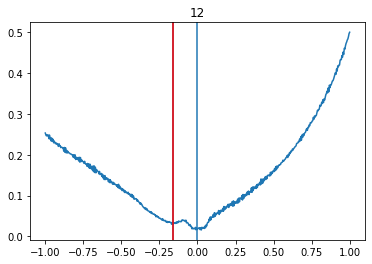

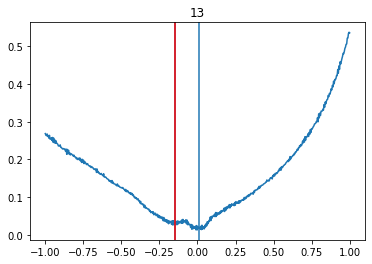

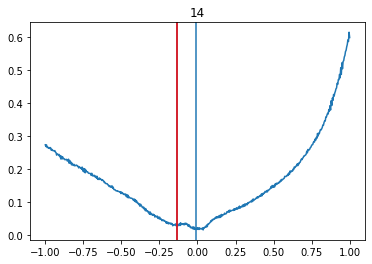

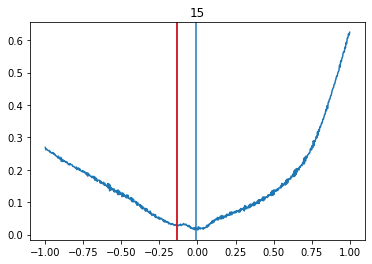

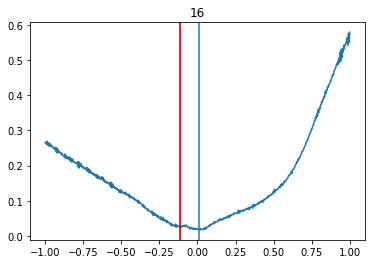

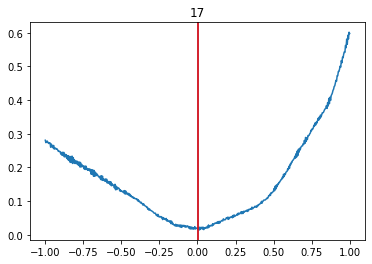

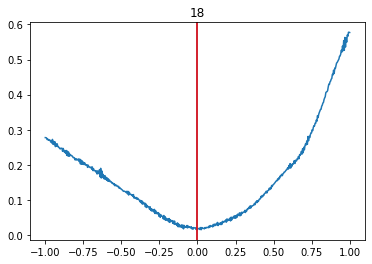

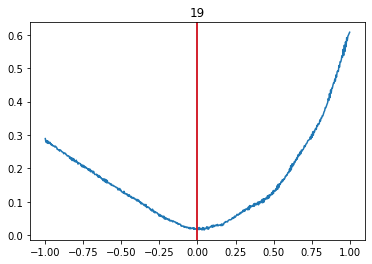

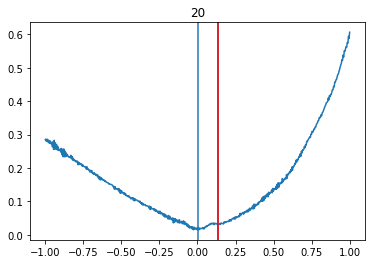

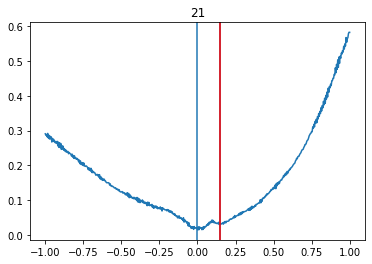

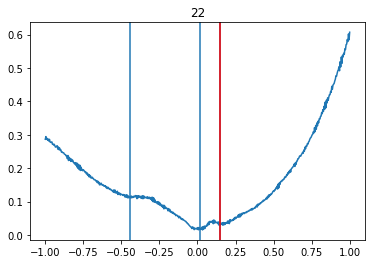

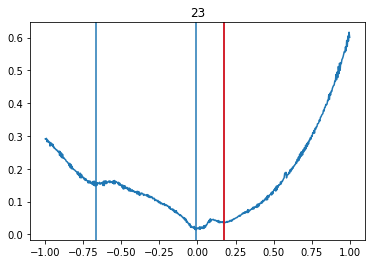

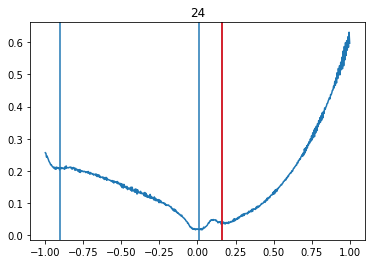

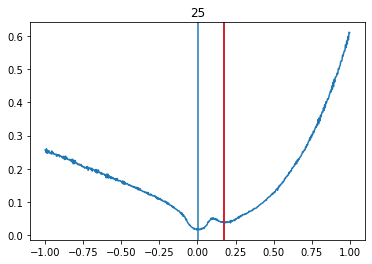

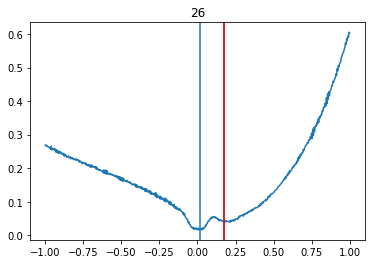

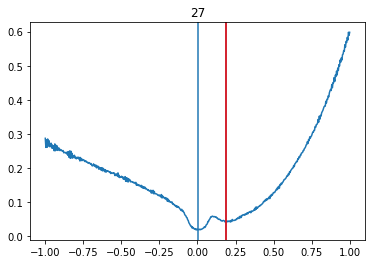

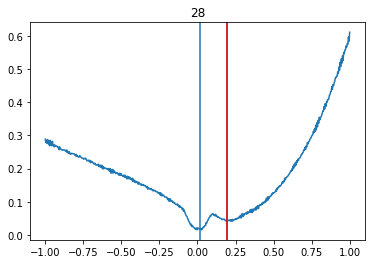

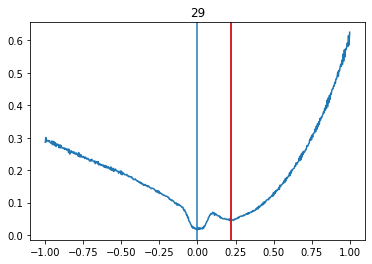

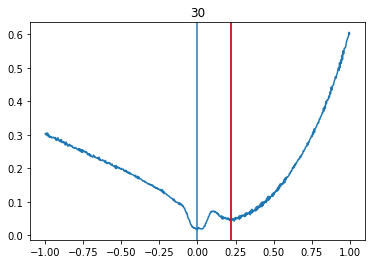

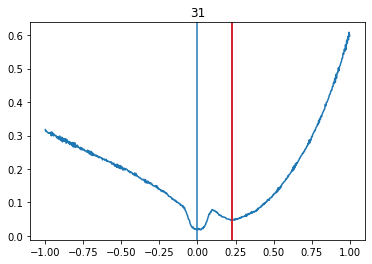

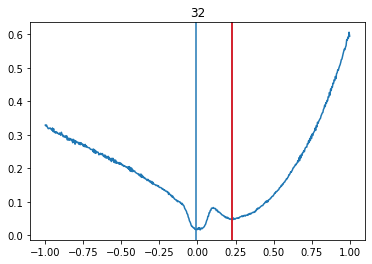

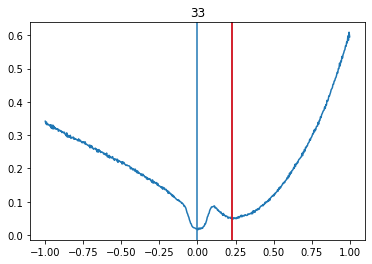

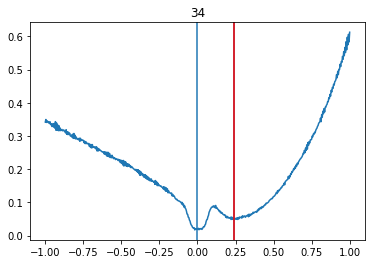

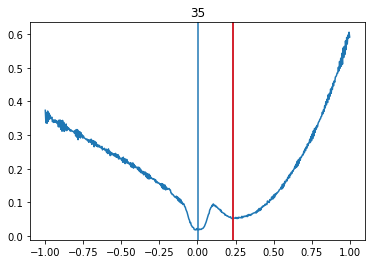

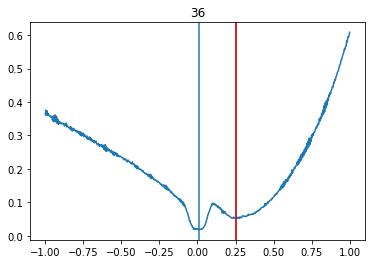

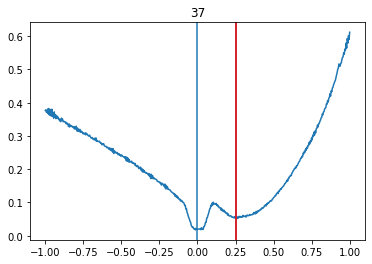

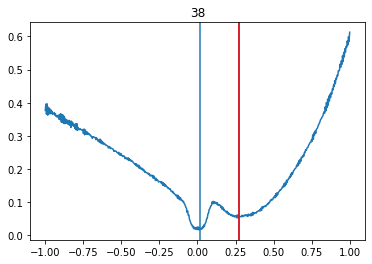

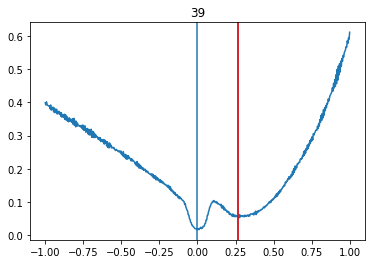

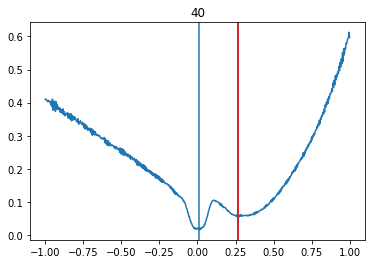

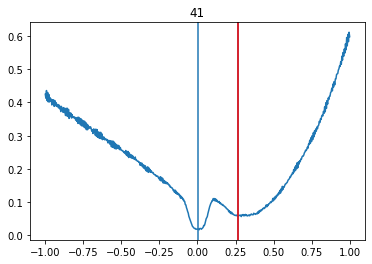

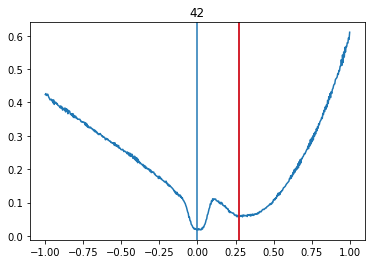

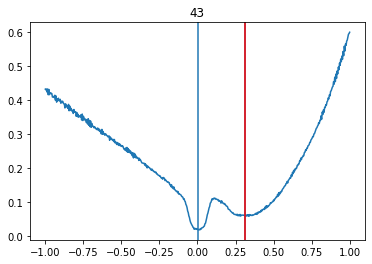

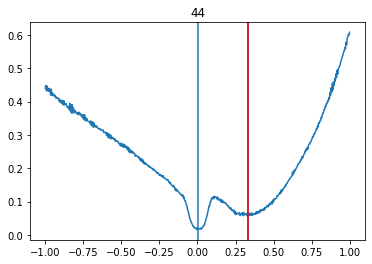

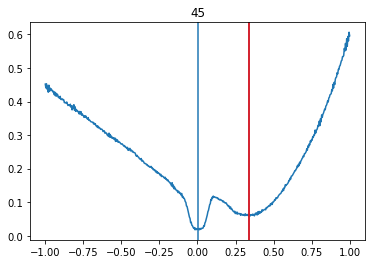

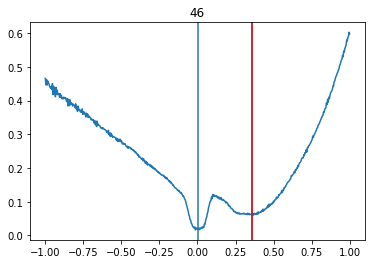

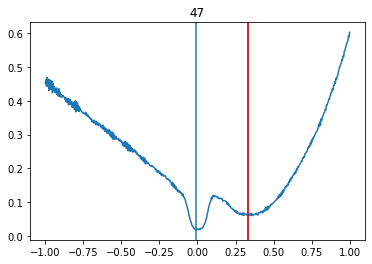

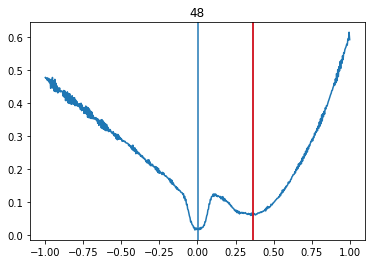

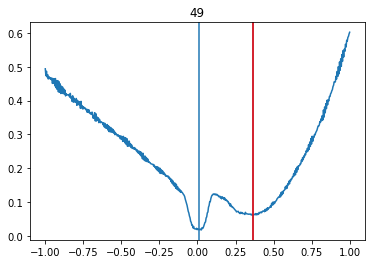

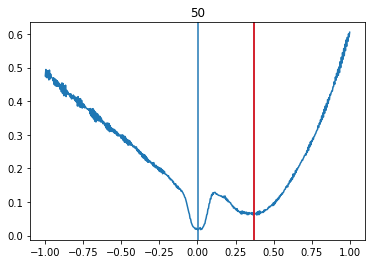

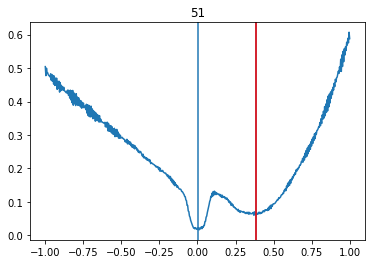

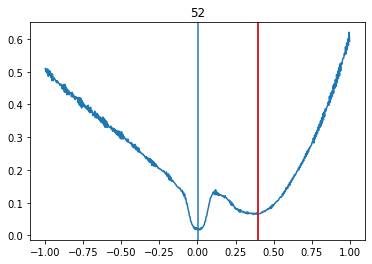

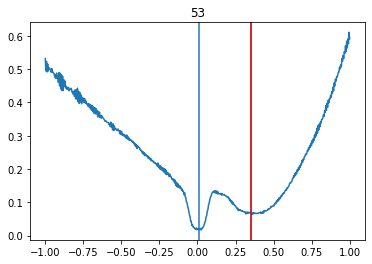

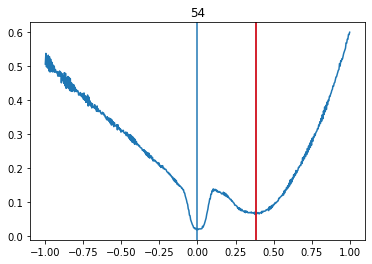

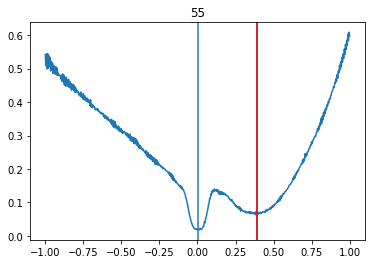

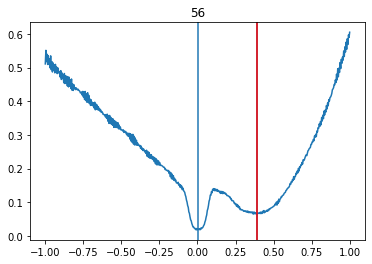

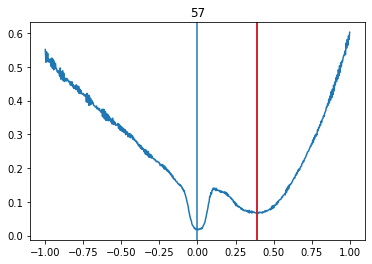

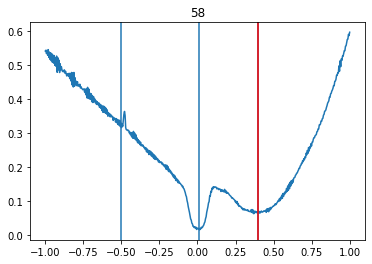

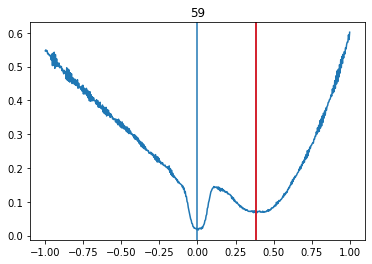

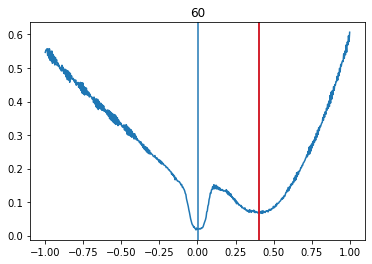

In [107]:
from scipy import signal
N_RANGE = (1, 62)
files = file_list(N_RANGE)
c = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 17:
        c.append(find_min(df, guess=-0.3, sig=2, dist=5, min_prom=5e-3, phon_correct=True, filenum=i))
    else:
        c.append(find_min(df, guess=0.3, sig=2, dist=5, min_prom=5e-3, phon_correct=True, filenum=i))
#     else:
#         c.append(find_min(df, guess=0.35, sig=6))

In [173]:
np.array(c[::-1])[np.isin(V, np.arange(-60, 10, 10))]

array([0.401174, 0.393346, 0.369863, 0.338552, 0.264188, 0.232877,
       0.221135])

[-0.232877,
 -0.23679099999999997,
 -0.23679099999999997,
 -0.221135,
 -0.189824,
 -0.19373800000000002,
 -0.209393,
 -0.221135,
 -0.189824,
 -0.205479,
 -0.17416800000000002,
 -0.16634100000000002,
 -0.162427,
 -0.15068499999999999,
 -0.135029,
 -0.135029,
 -0.111546,
 0.00587084,
 -0.00195695,
 -0.00587084,
 0.135029,
 0.15068499999999999,
 0.15068499999999999,
 0.17416800000000002,
 0.15851300000000001,
 0.17416800000000002,
 0.17416800000000002,
 0.189824,
 0.19373800000000002,
 0.221135,
 0.221135,
 0.22504899999999997,
 0.22504899999999997,
 0.228963,
 0.24070500000000003,
 0.232877,
 0.252446,
 0.25636,
 0.27593,
 0.268102,
 0.26418800000000003,
 0.26418800000000003,
 0.272016,
 0.31506799999999996,
 0.33072399999999996,
 0.338552,
 0.358121,
 0.33072399999999996,
 0.362035,
 0.362035,
 0.369863,
 0.385519,
 0.39726,
 0.354207,
 0.385519,
 0.39334600000000003,
 0.389432,
 0.389432,
 0.39726,
 0.385519,
 0.401174]

(-0.3, 0.5)

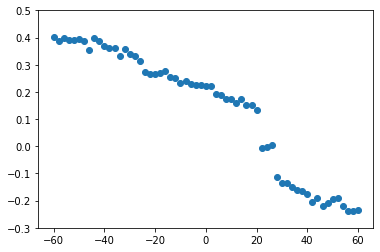

In [108]:
V = np.linspace(-60, 60, 61)
plt.plot(V, np.array(c[::-1]), 'o')
plt.ylim(-0.3, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


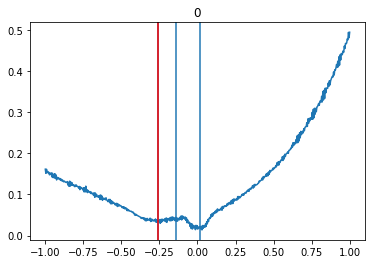

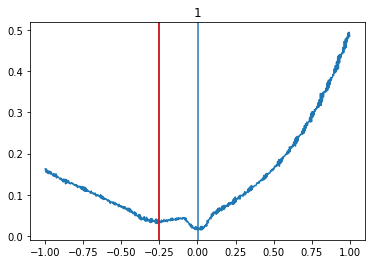

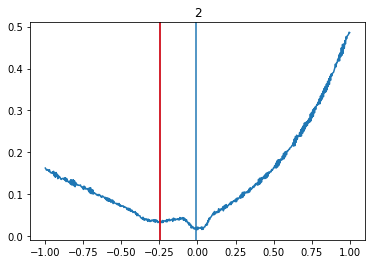

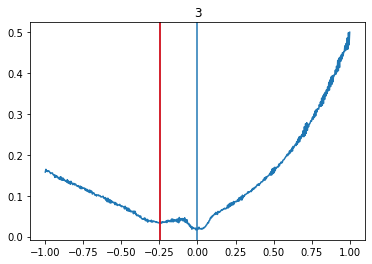

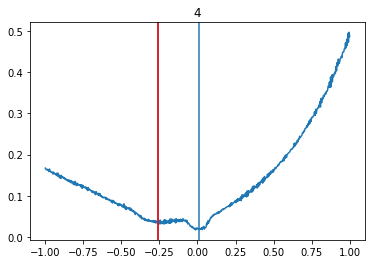

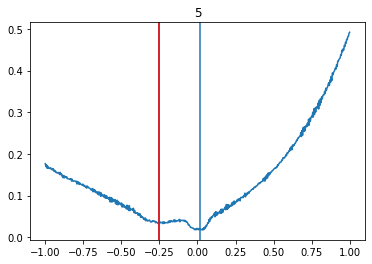

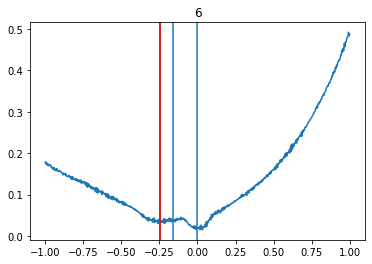

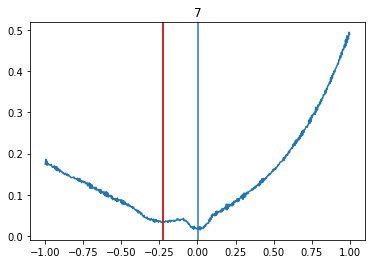

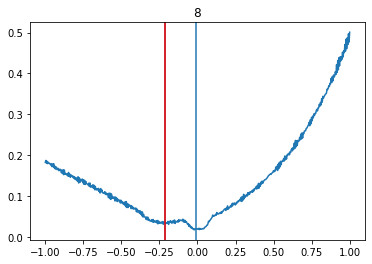

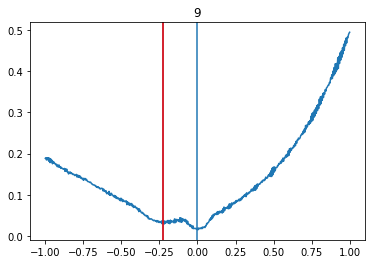

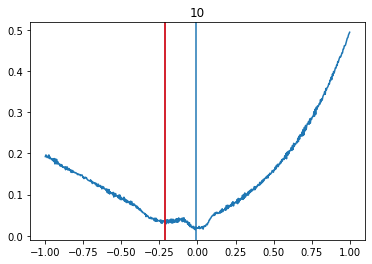

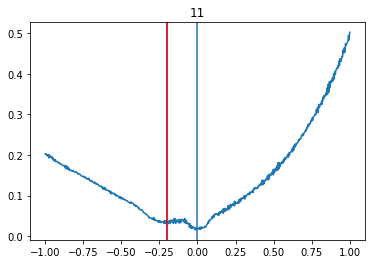

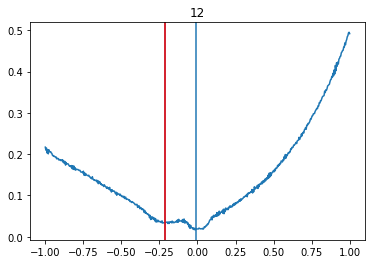

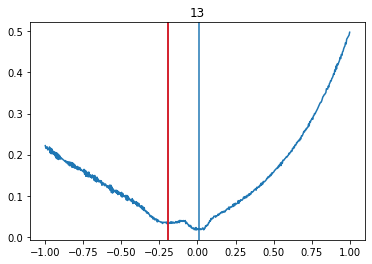

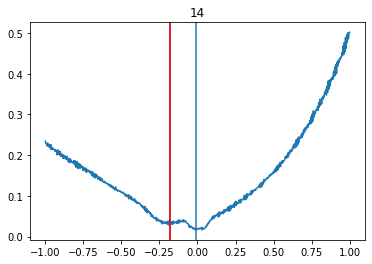

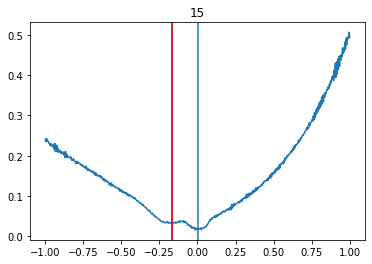

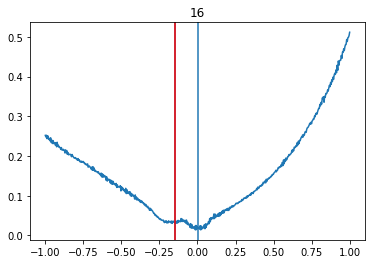

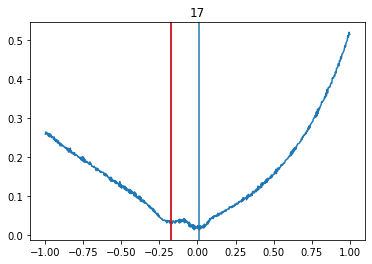

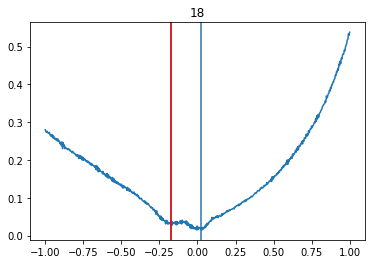

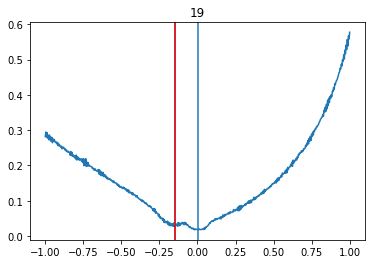

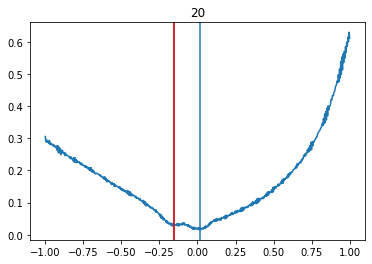

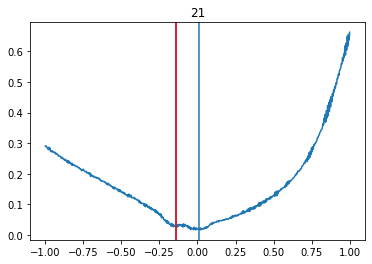

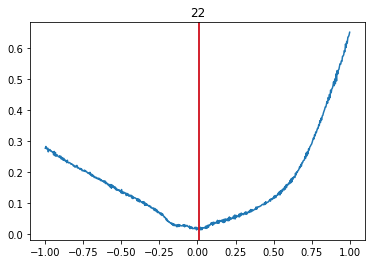

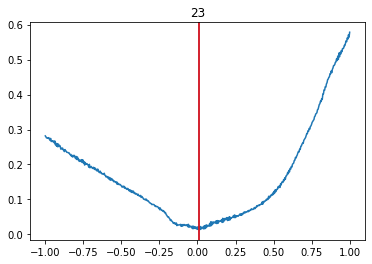

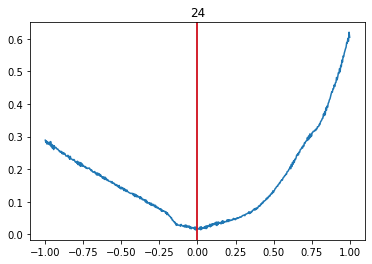

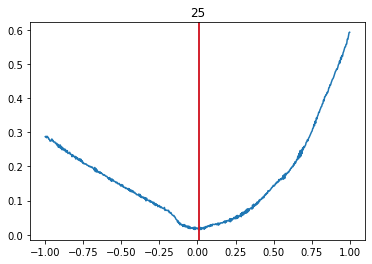

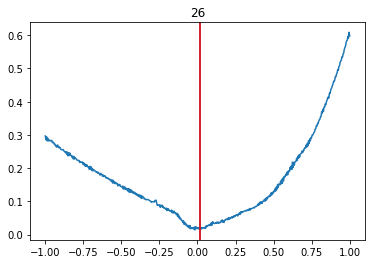

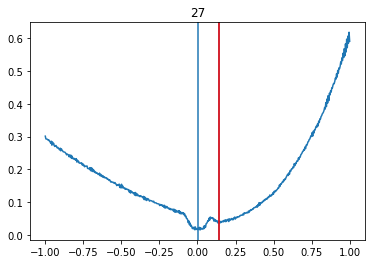

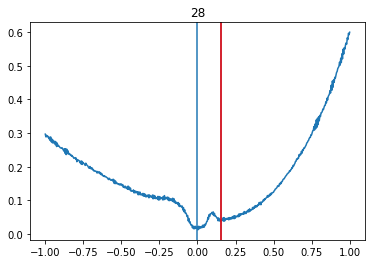

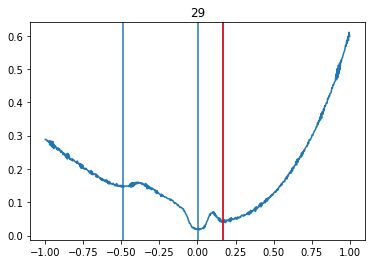

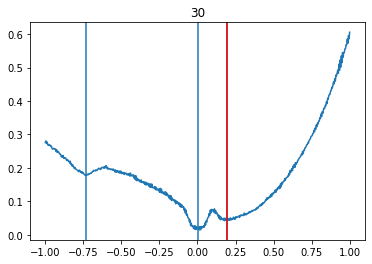

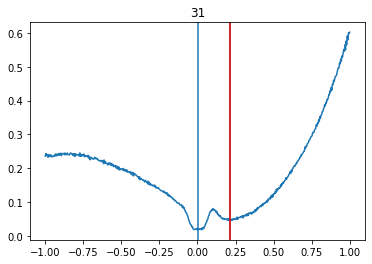

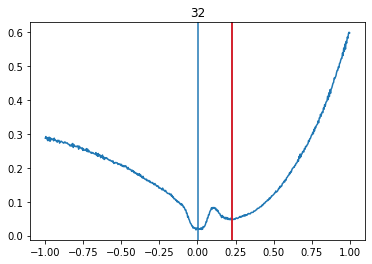

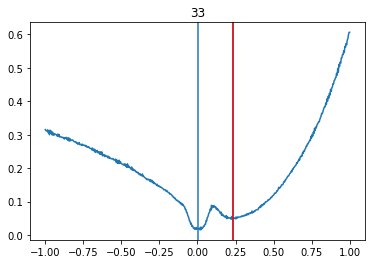

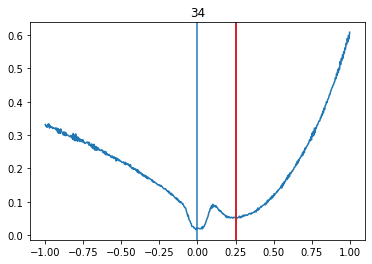

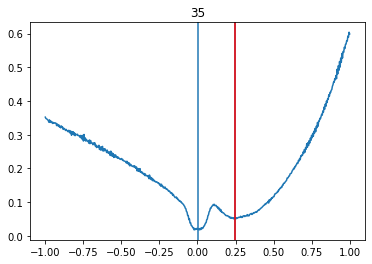

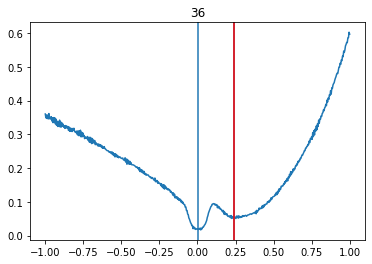

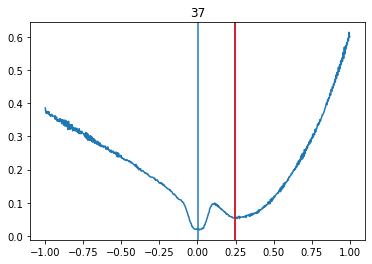

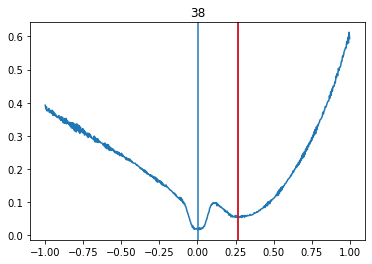

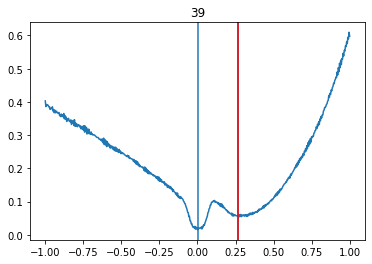

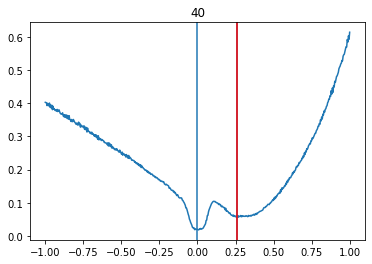

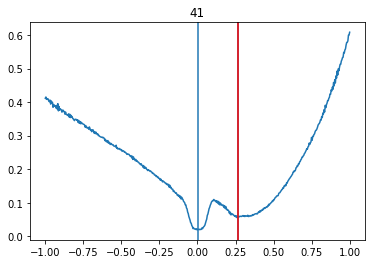

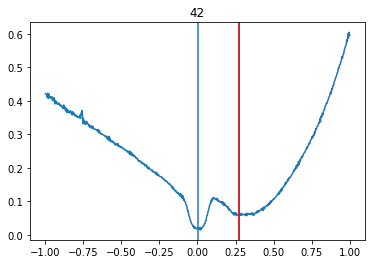

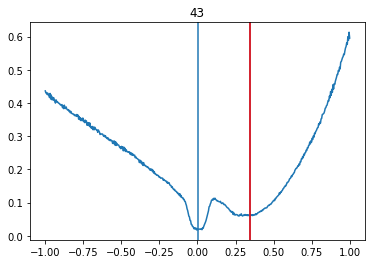

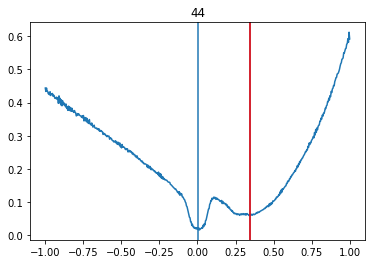

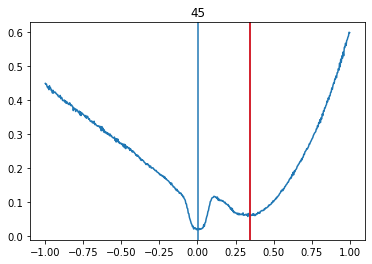

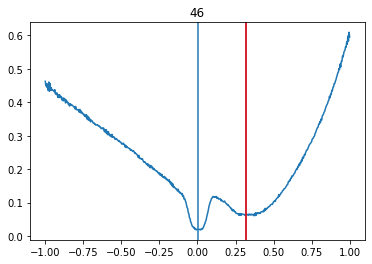

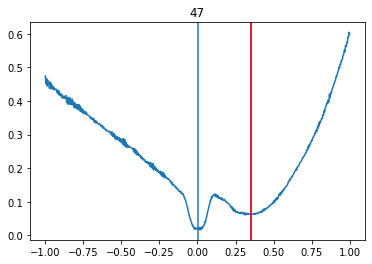

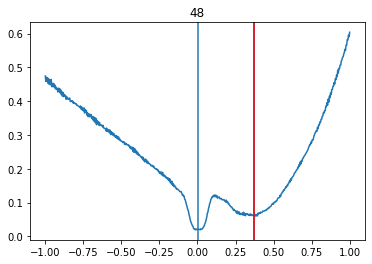

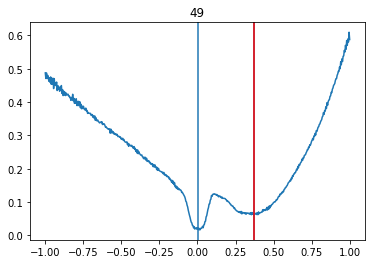

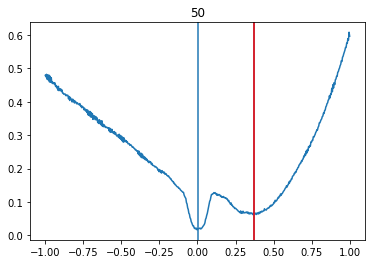

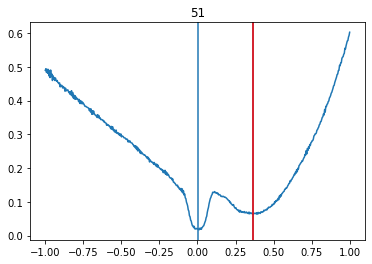

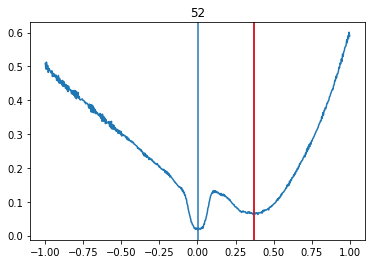

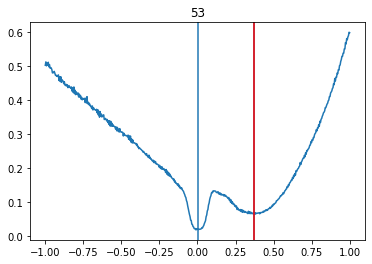

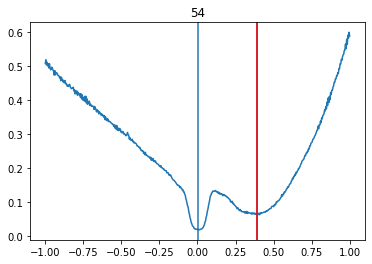

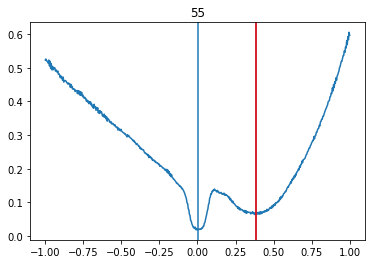

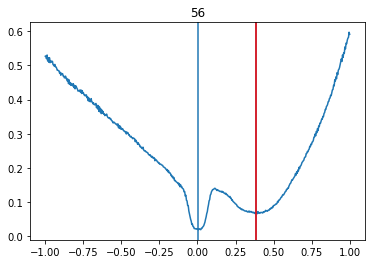

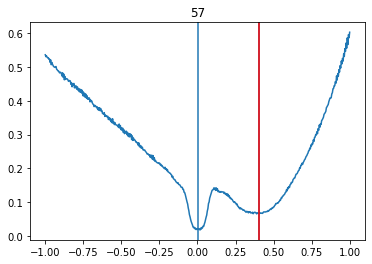

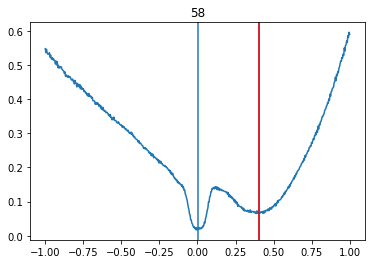

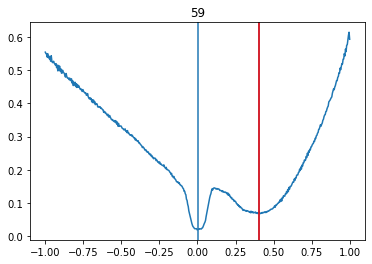

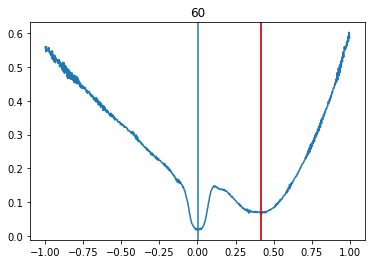

In [114]:
N_RANGE = (62, 123)
files = file_list(N_RANGE)
d = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 27:
        d.append(find_min(df, guess=-0.3, sig=3, dist=5, min_prom=3e-3, phon_correct=True, filenum=i))
    else:
        d.append(find_min(df, guess=0.3, sig=3, dist=5, min_prom=8e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

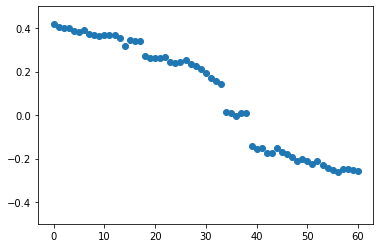

In [116]:
plt.plot(np.array(d[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


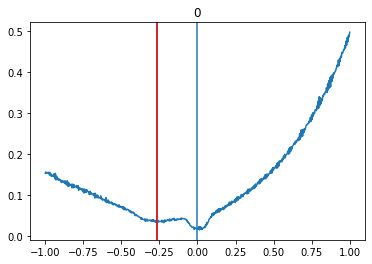

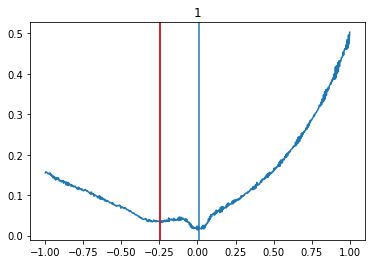

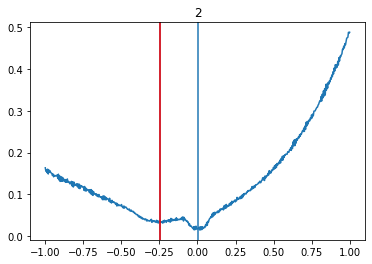

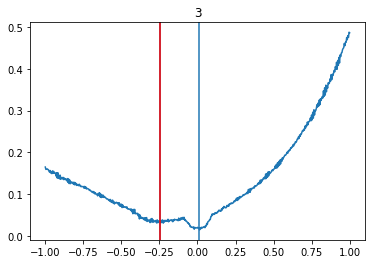

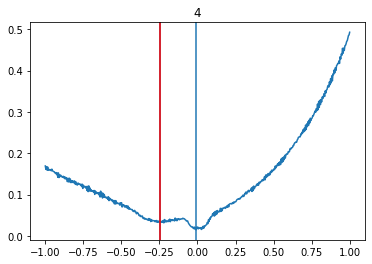

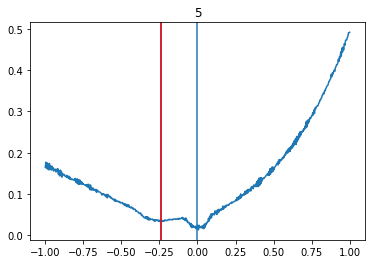

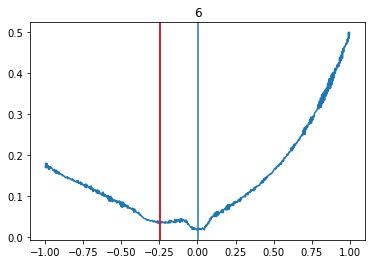

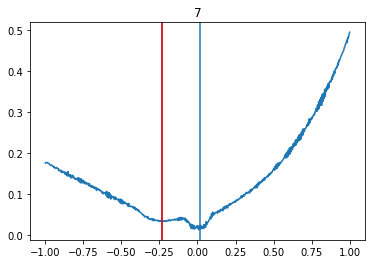

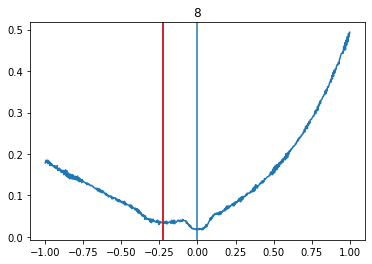

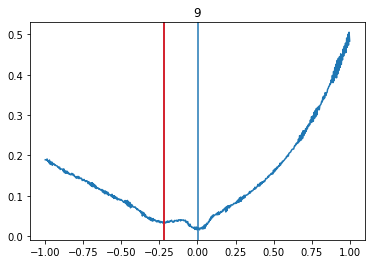

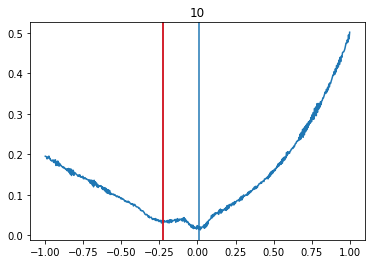

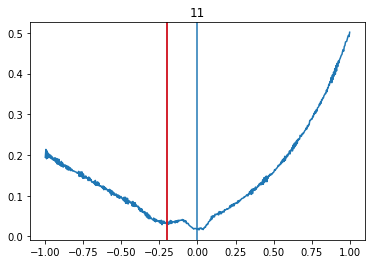

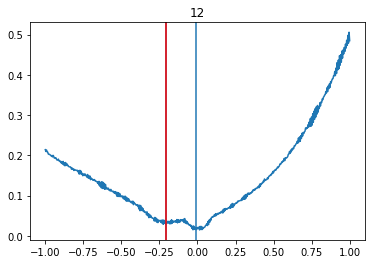

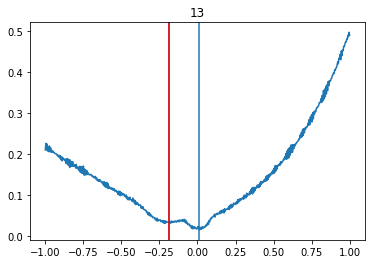

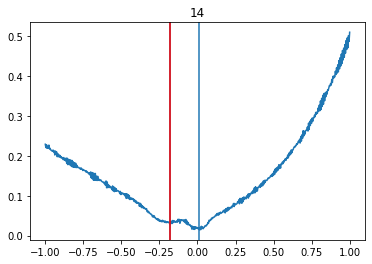

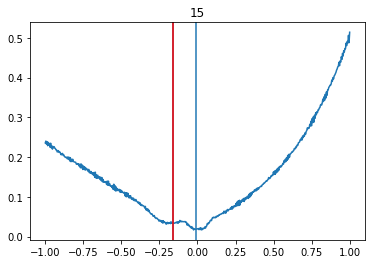

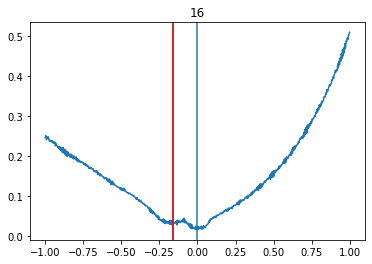

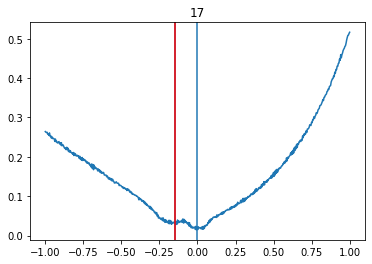

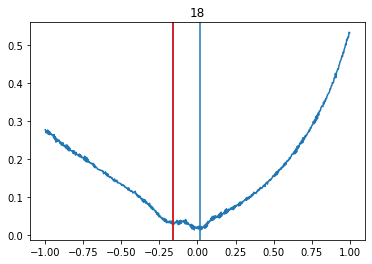

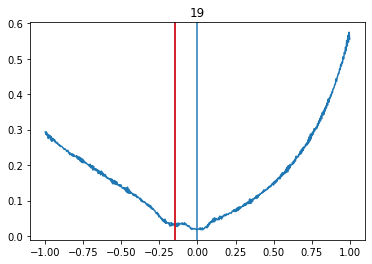

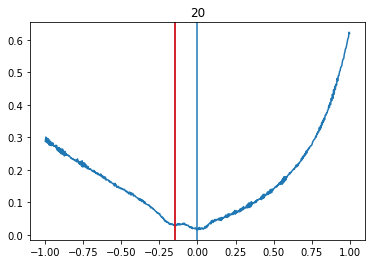

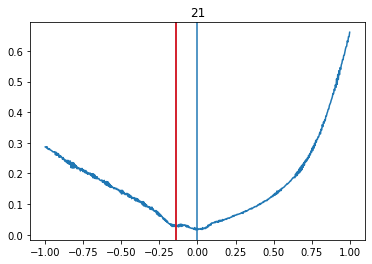

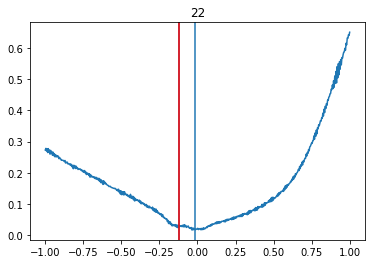

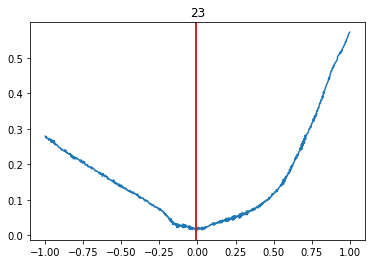

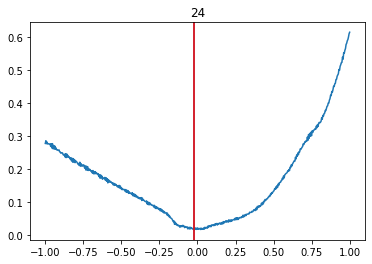

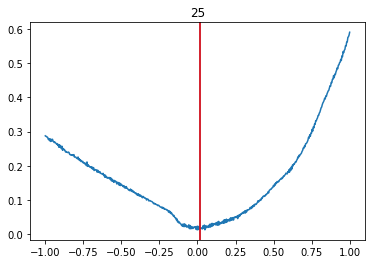

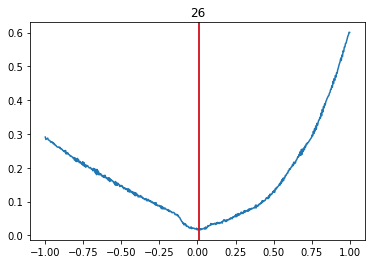

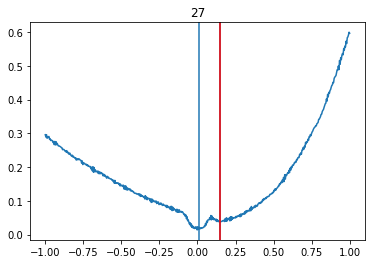

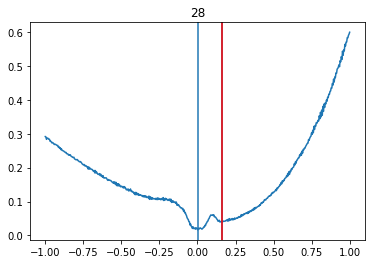

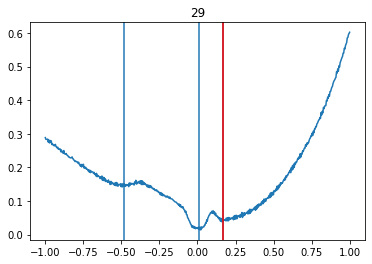

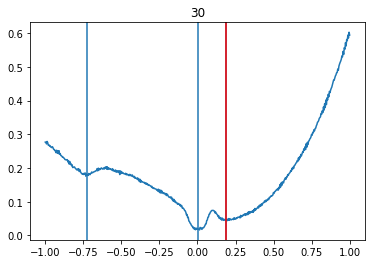

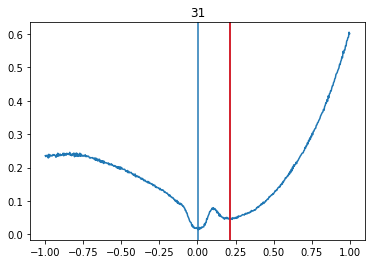

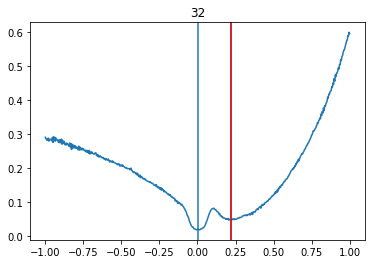

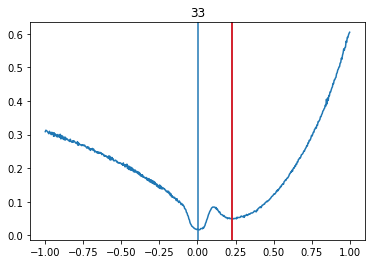

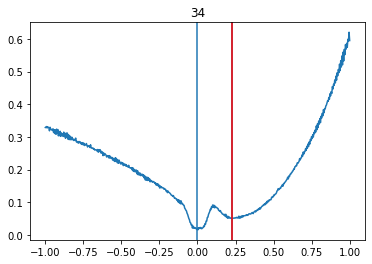

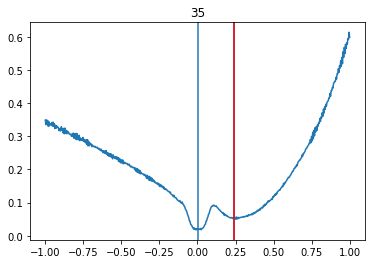

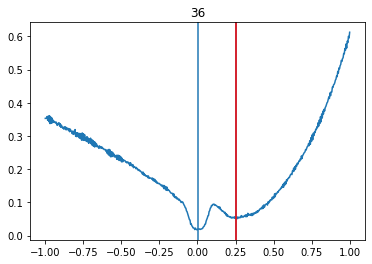

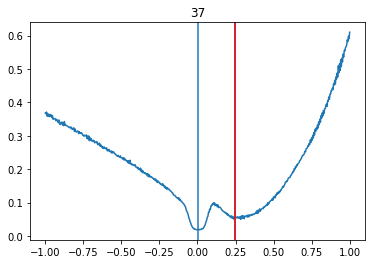

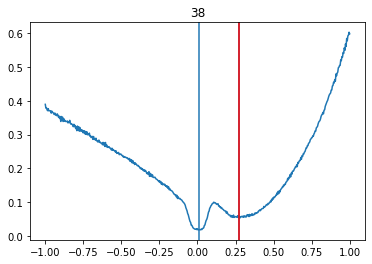

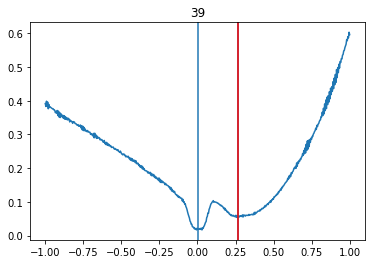

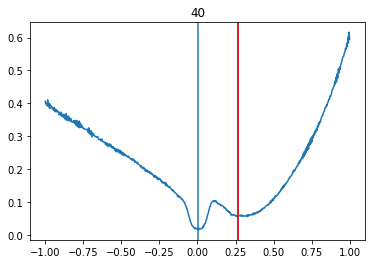

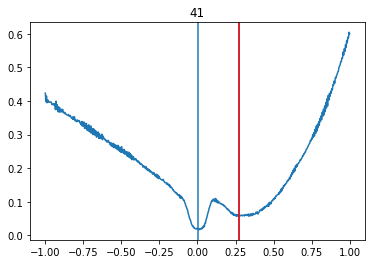

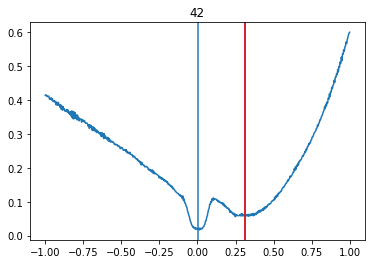

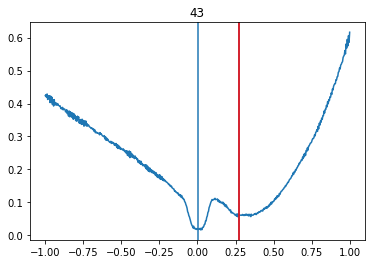

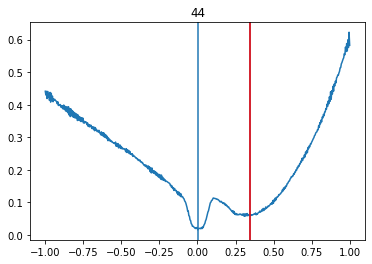

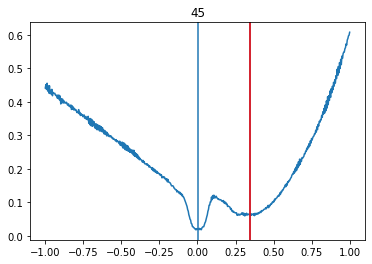

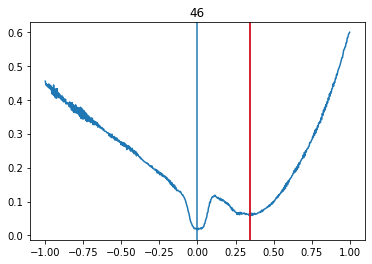

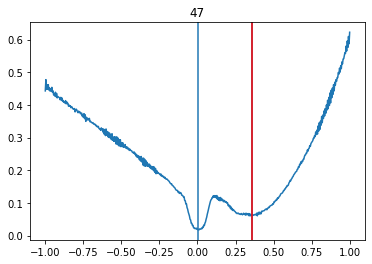

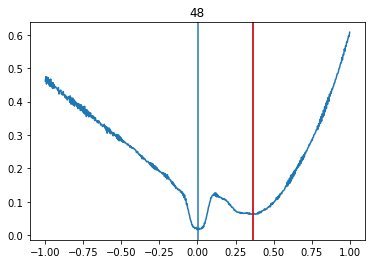

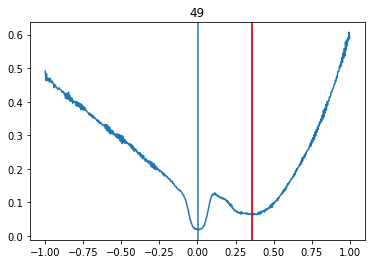

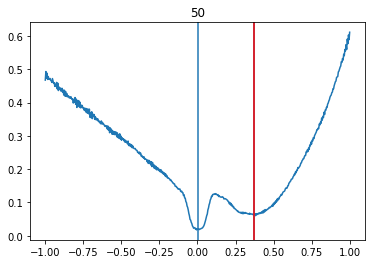

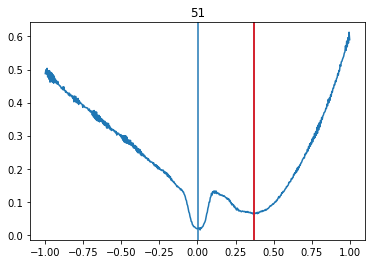

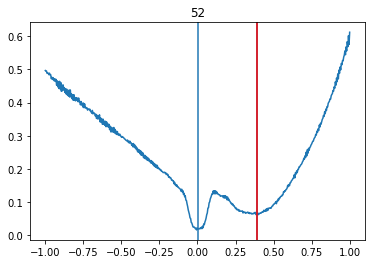

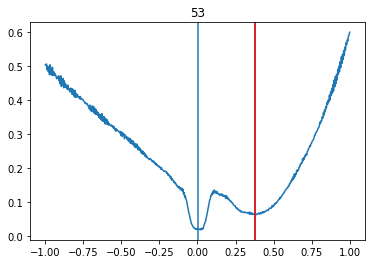

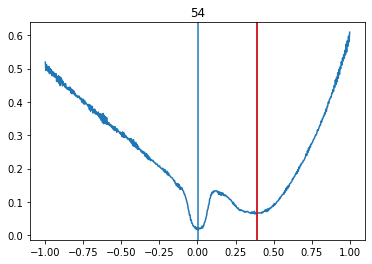

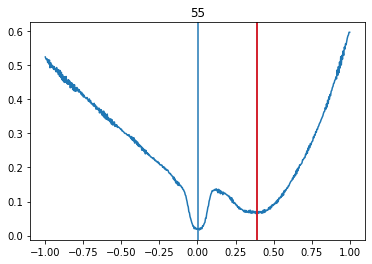

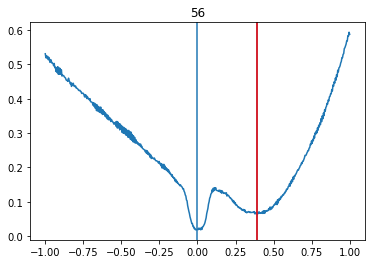

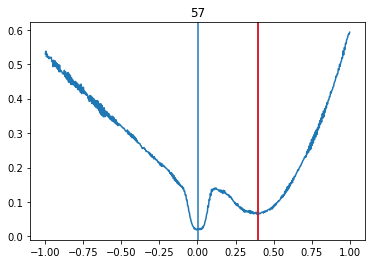

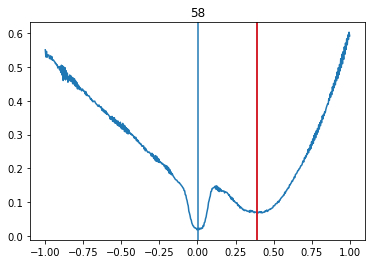

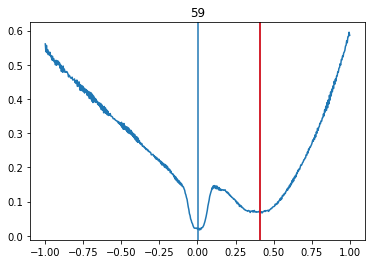

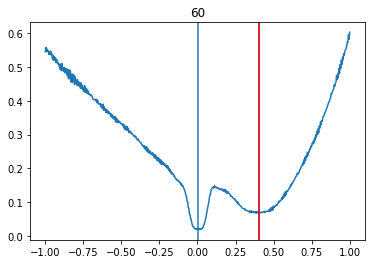

In [120]:
N_RANGE = (123, 184)
files = file_list(N_RANGE)
e = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 26:
        e.append(find_min(df, guess=-0.3, sig=3, dist=3, min_prom=1e-3, phon_correct=True, filenum=i))
    else:
        e.append(find_min(df, guess=0.3, sig=3, dist=3, min_prom=7e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

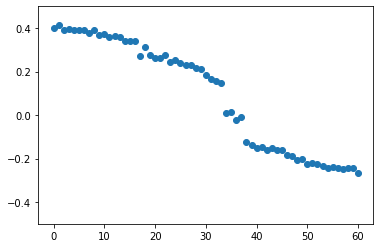

In [121]:
plt.plot(np.array(e[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


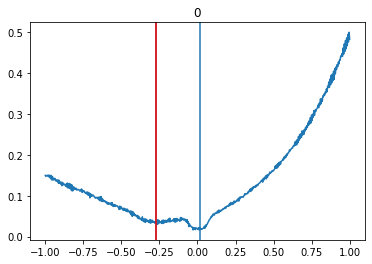

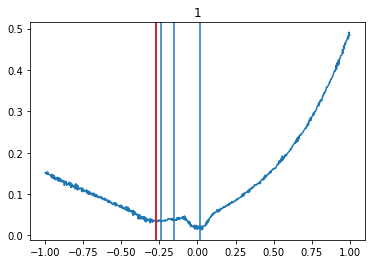

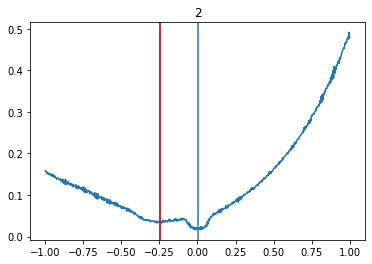

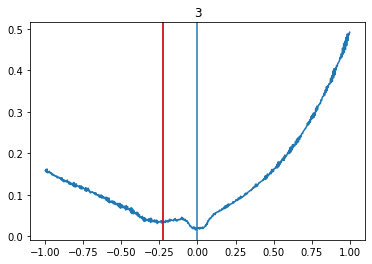

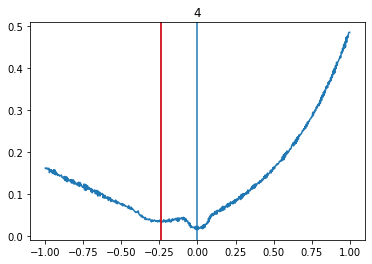

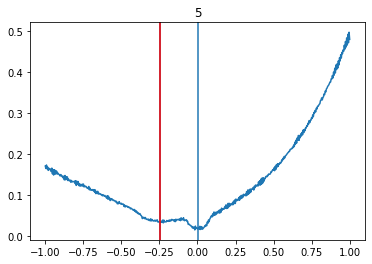

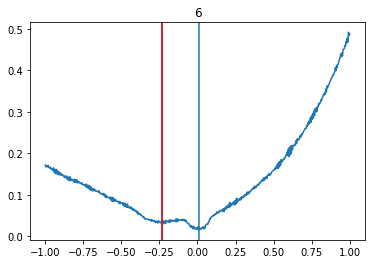

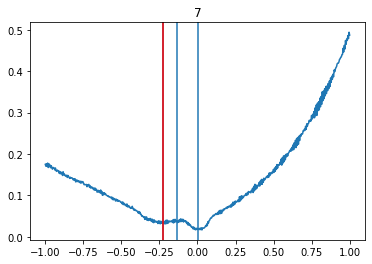

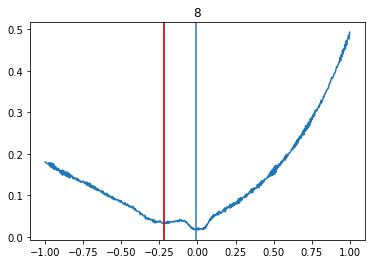

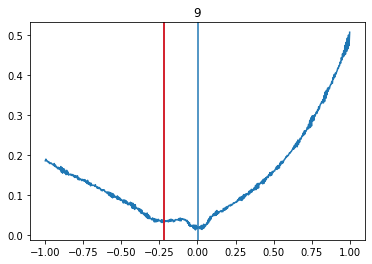

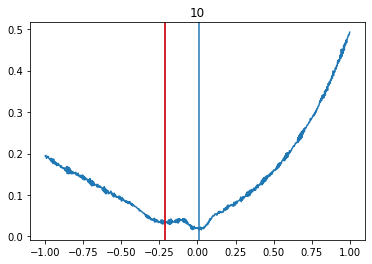

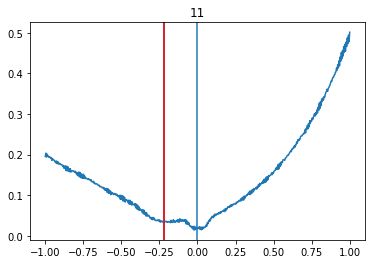

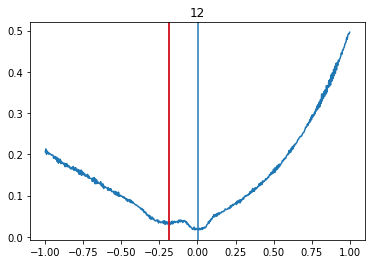

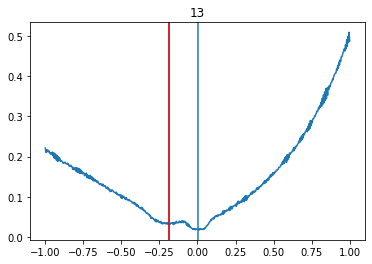

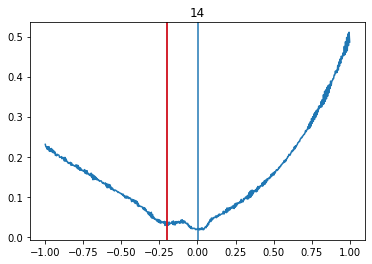

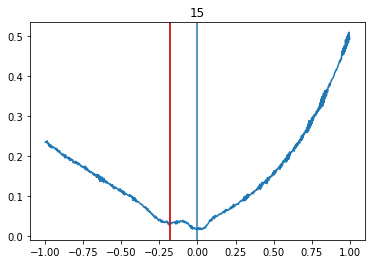

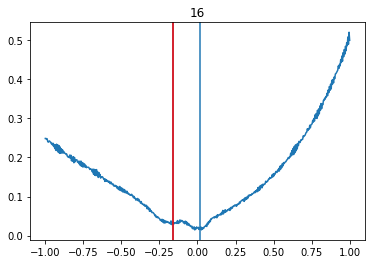

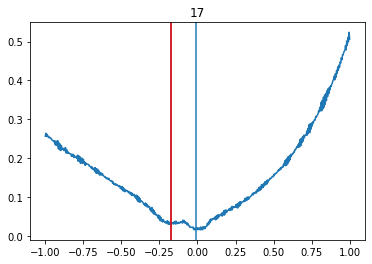

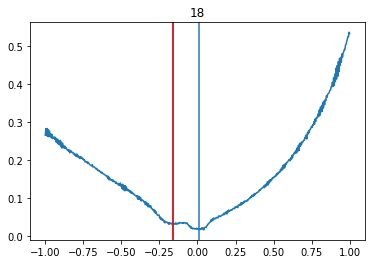

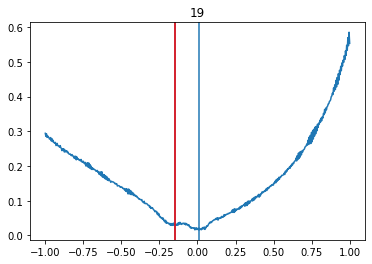

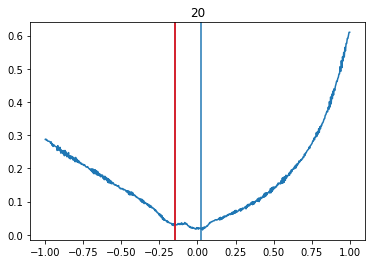

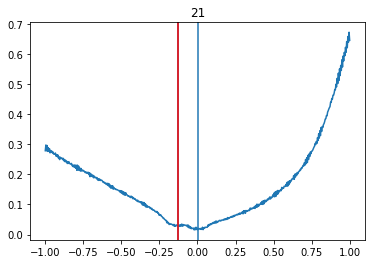

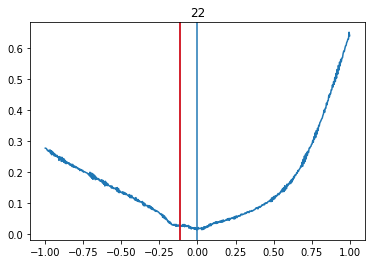

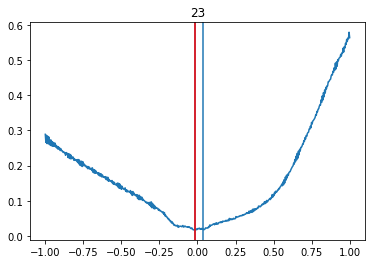

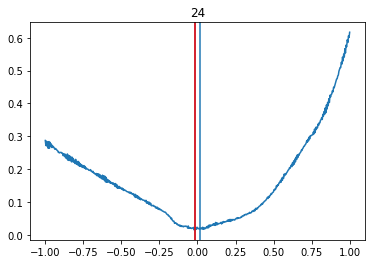

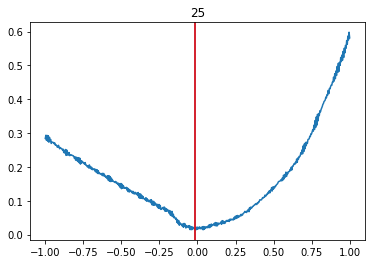

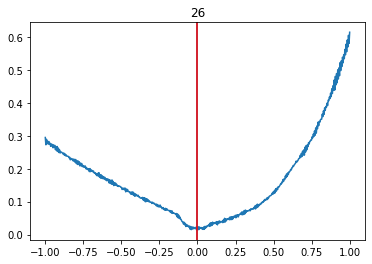

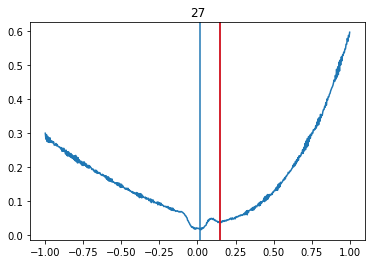

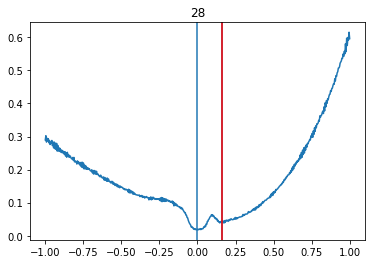

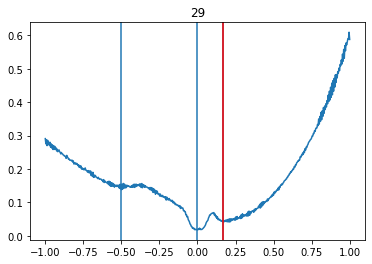

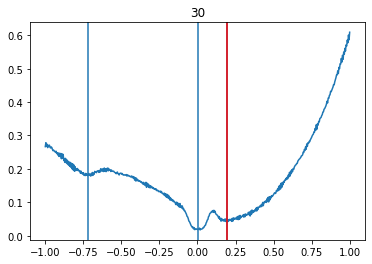

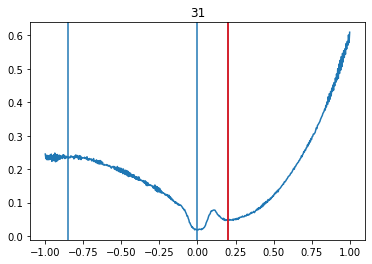

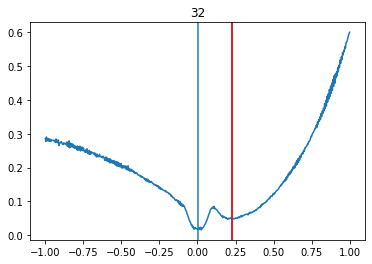

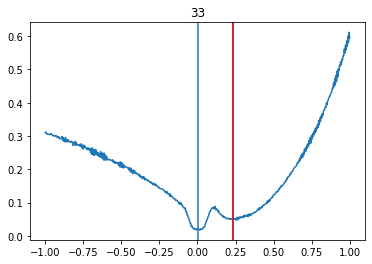

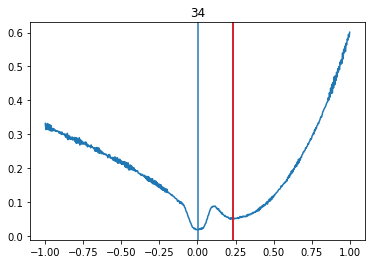

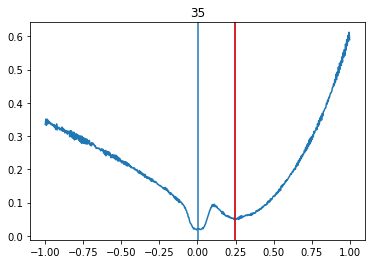

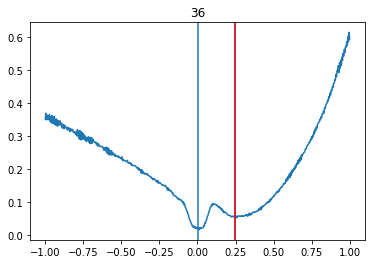

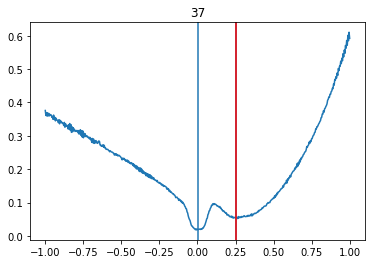

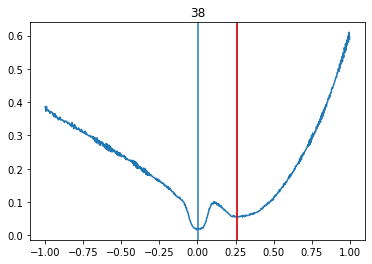

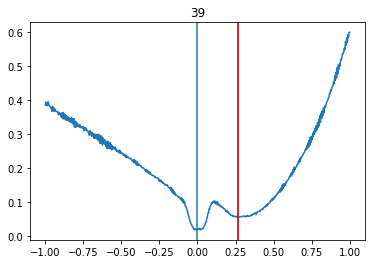

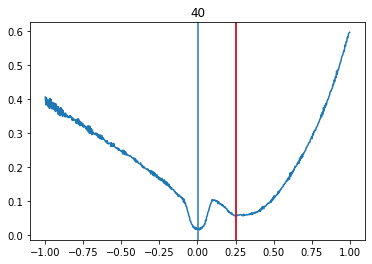

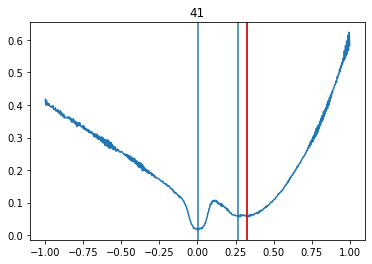

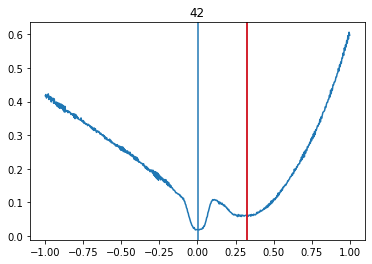

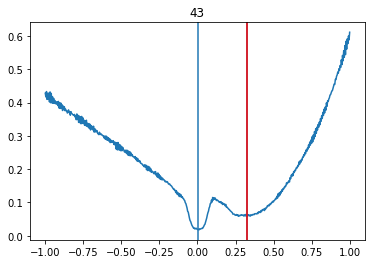

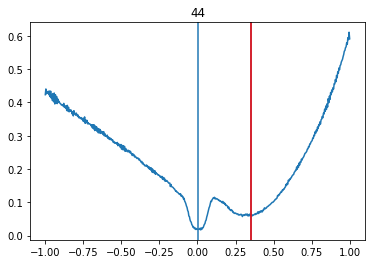

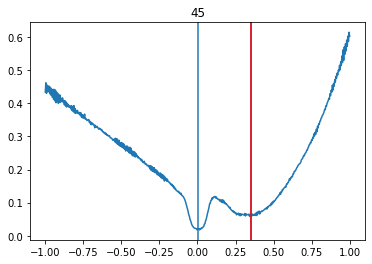

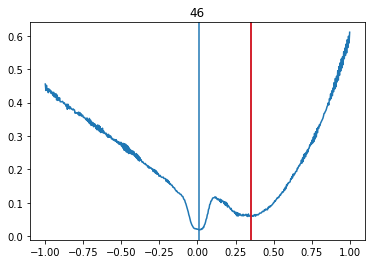

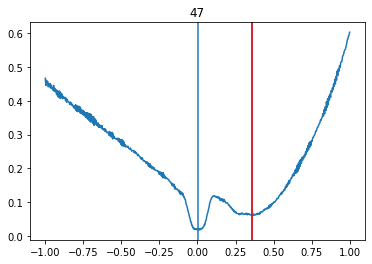

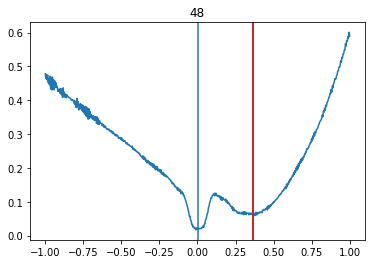

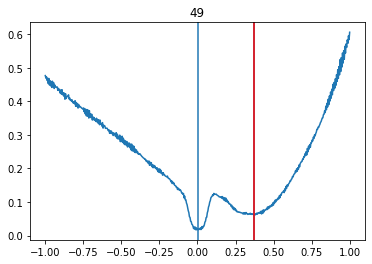

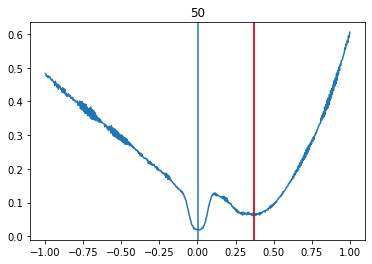

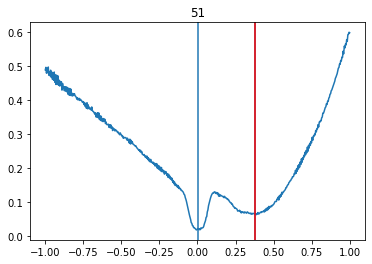

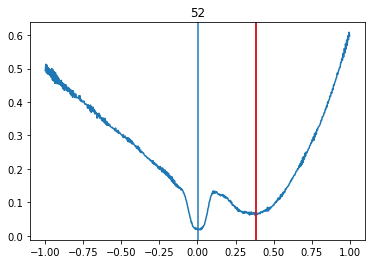

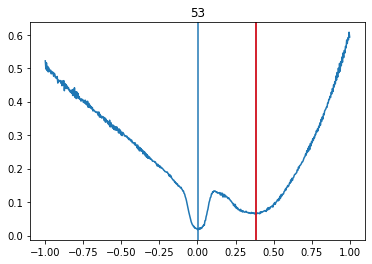

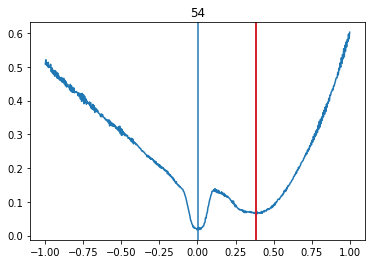

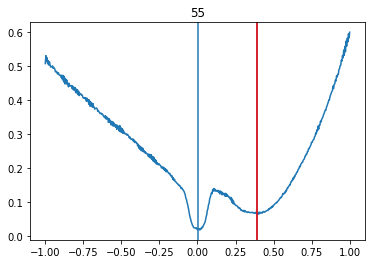

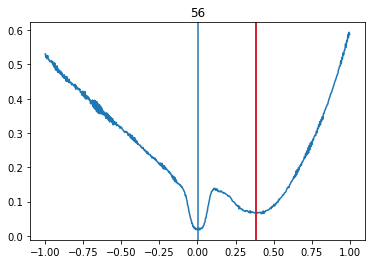

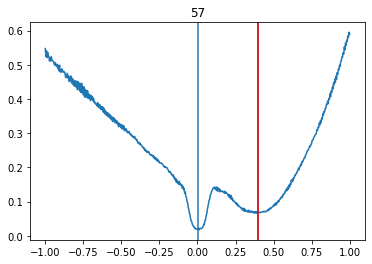

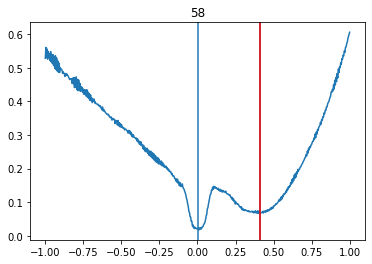

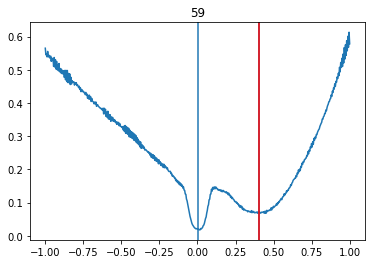

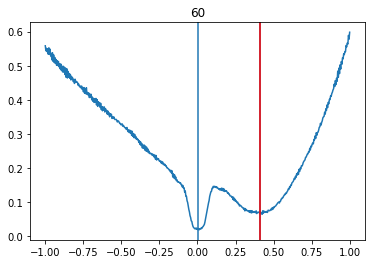

In [123]:
N_RANGE = (184, 245)
files = file_list(N_RANGE)
g = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 26:
        g.append(find_min(df, guess=-0.3, sig=3, dist=3, min_prom=1e-3, phon_correct=True, filenum=i))
    else:
        g.append(find_min(df, guess=0.3, sig=3, dist=3, min_prom=7e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

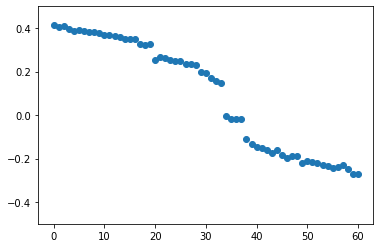

In [124]:
plt.plot(np.array(g[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


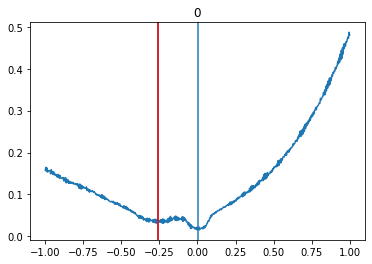

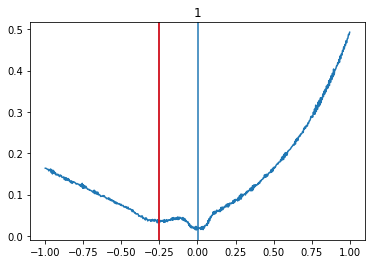

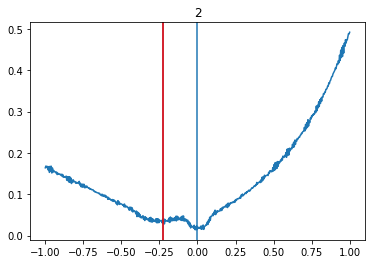

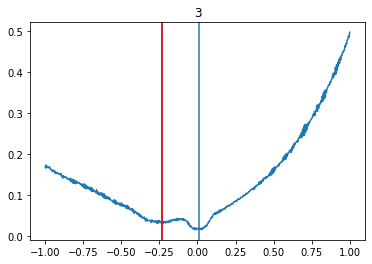

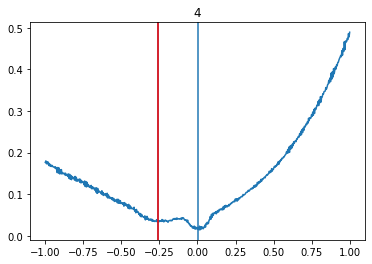

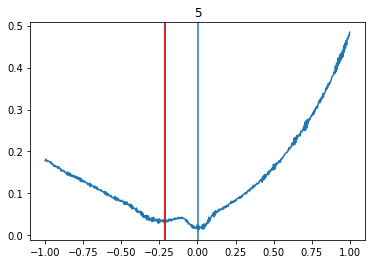

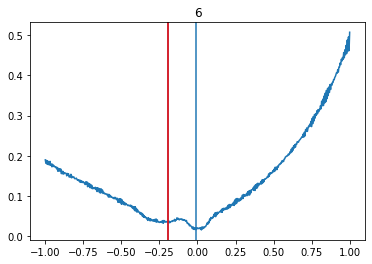

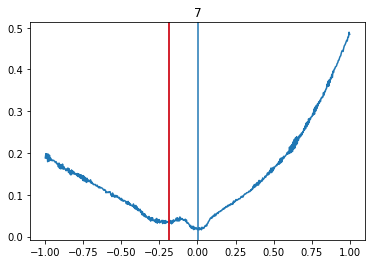

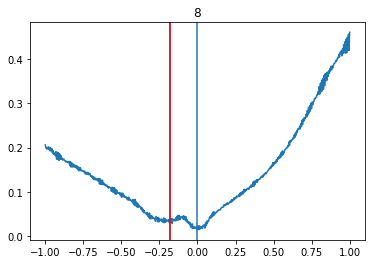

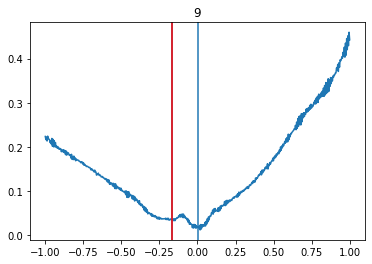

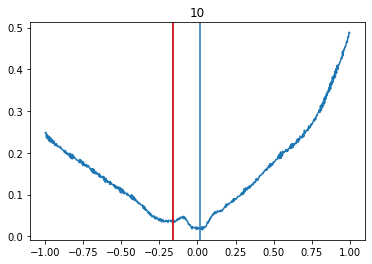

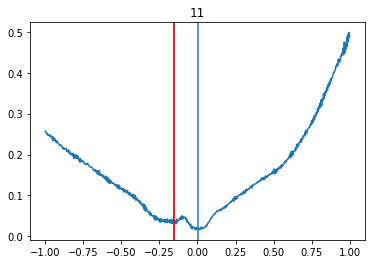

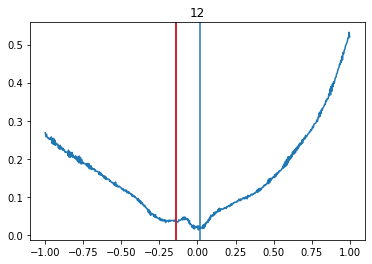

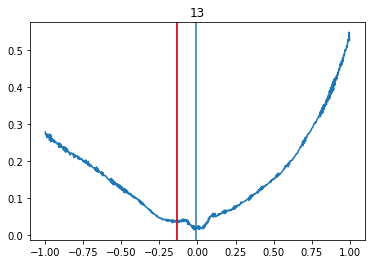

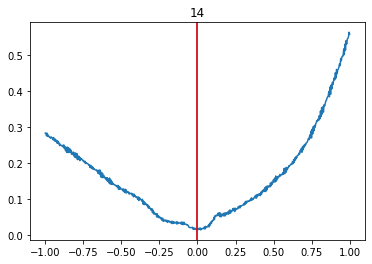

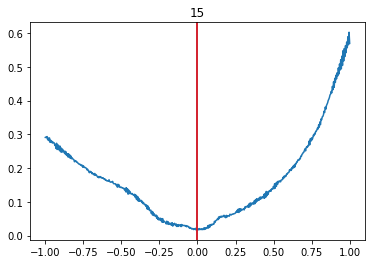

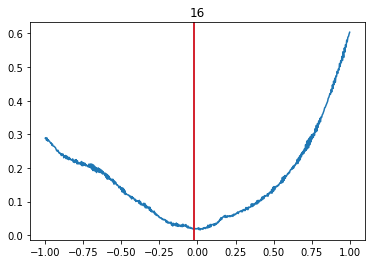

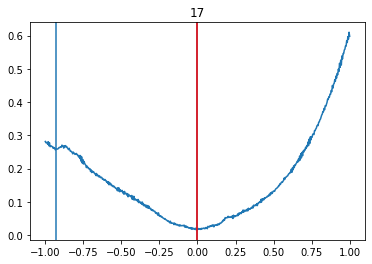

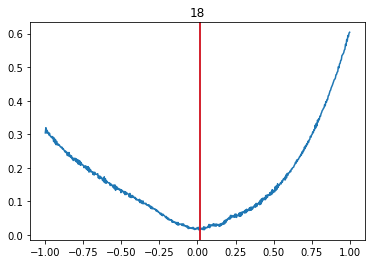

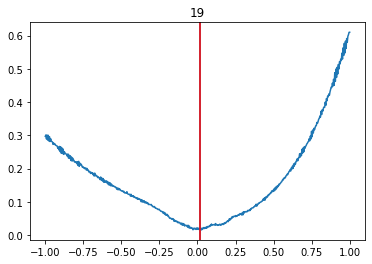

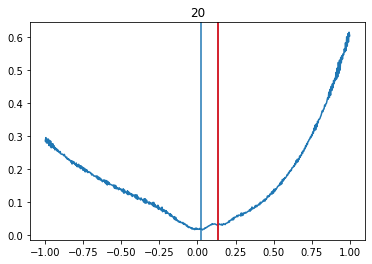

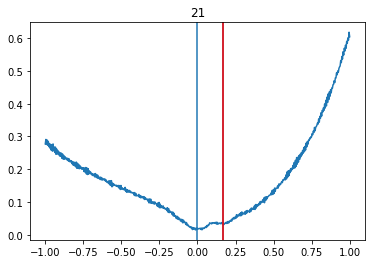

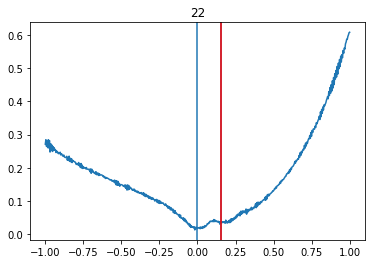

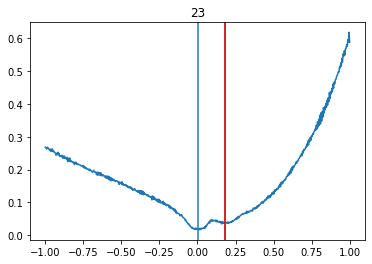

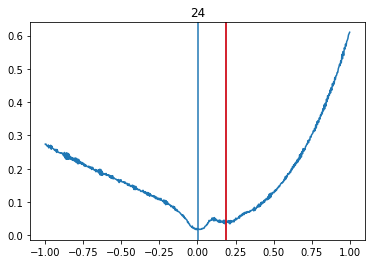

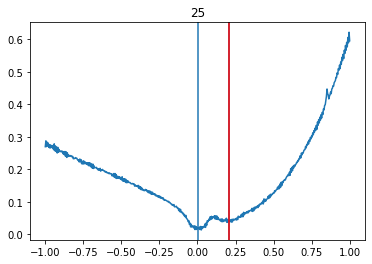

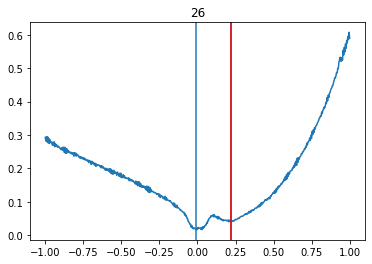

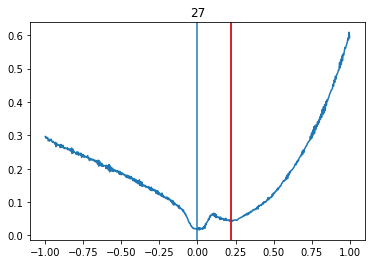

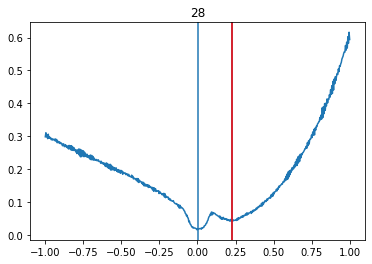

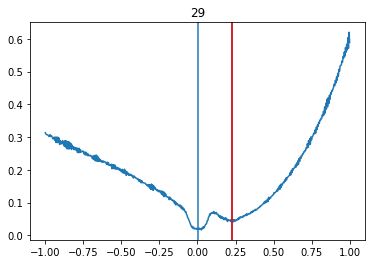

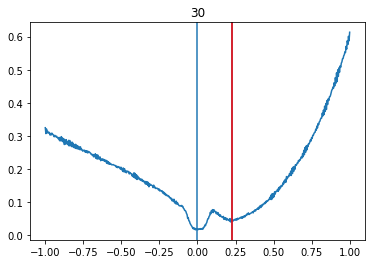

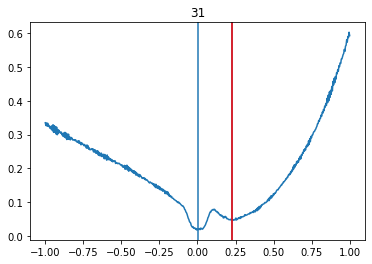

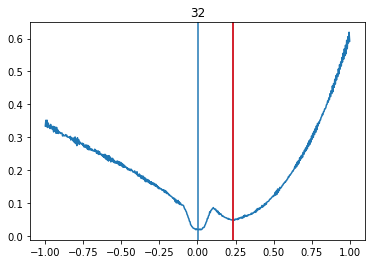

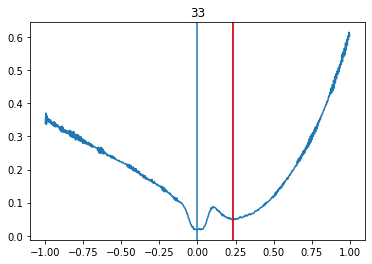

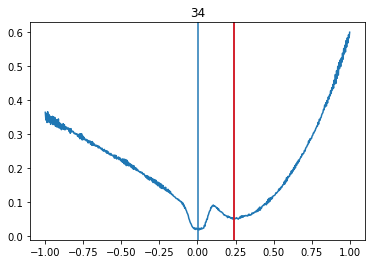

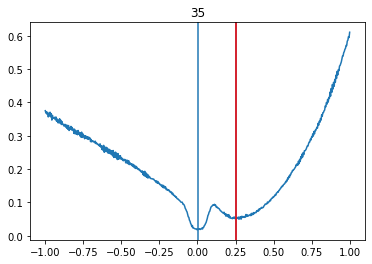

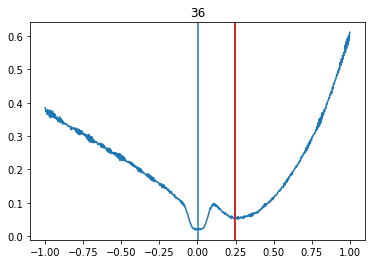

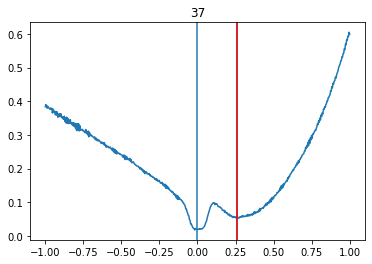

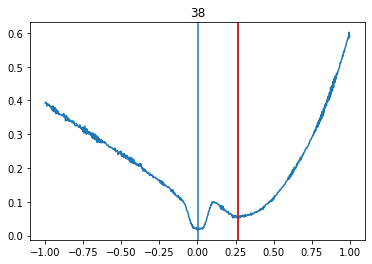

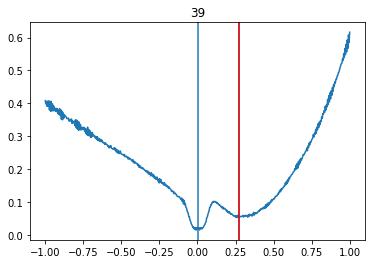

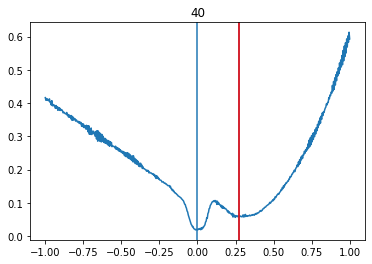

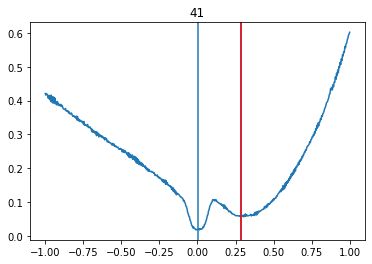

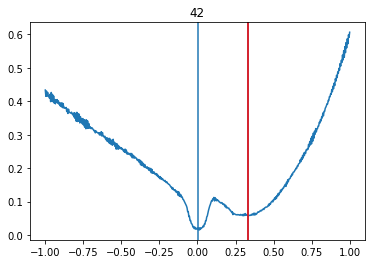

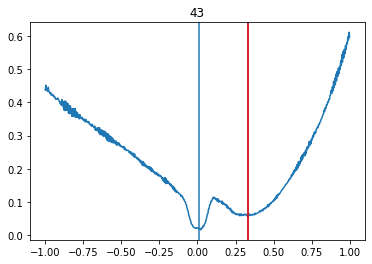

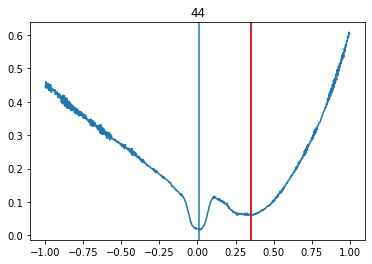

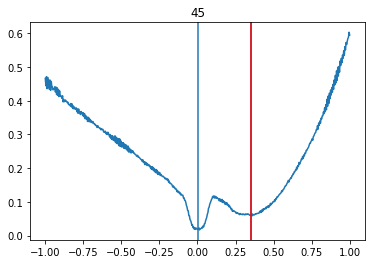

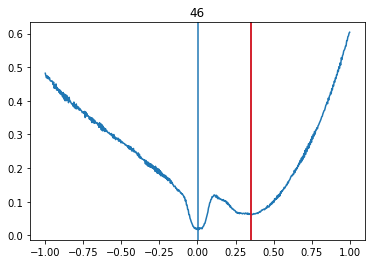

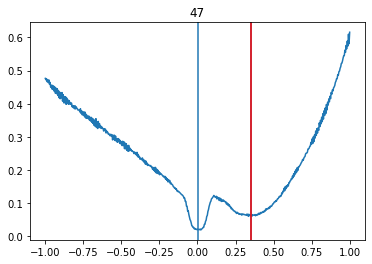

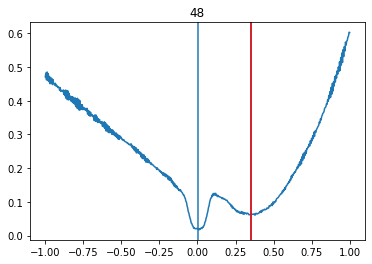

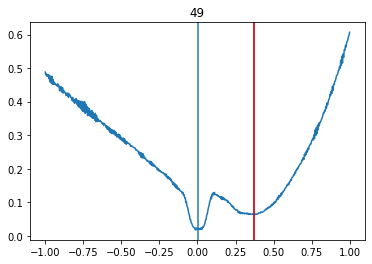

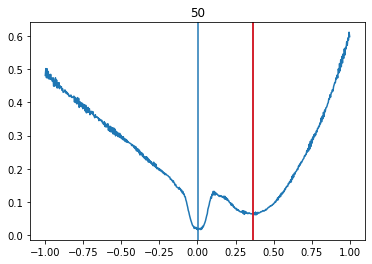

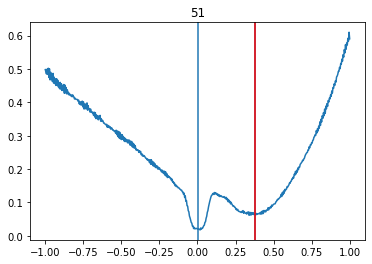

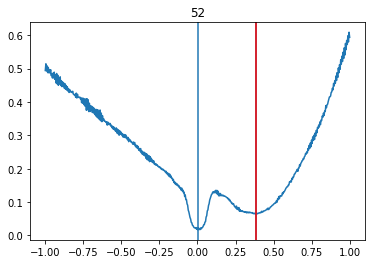

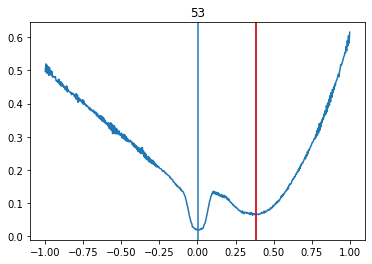

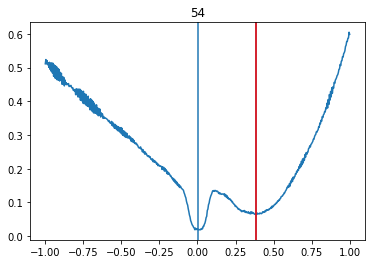

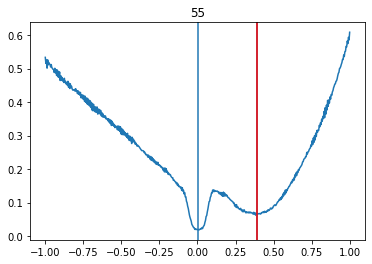

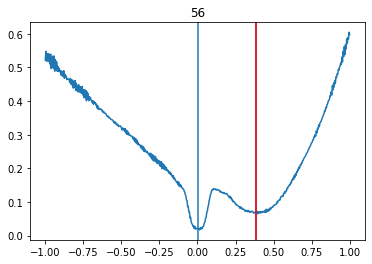

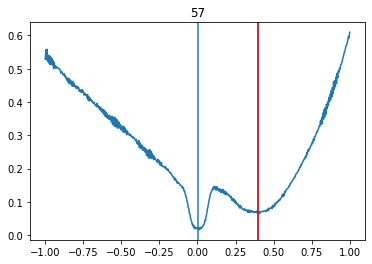

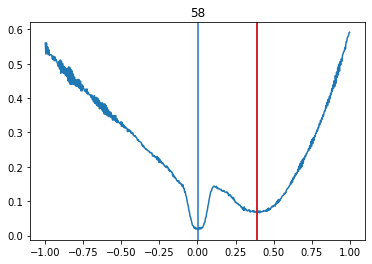

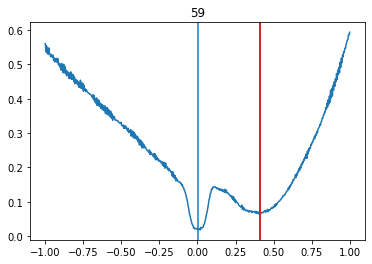

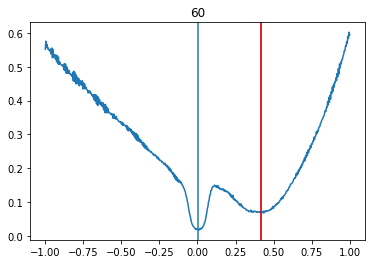

In [129]:
N_RANGE = (245, 306)
files = file_list(N_RANGE)
h = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 15:
        h.append(find_min(df, guess=-0.2, sig=3, dist=3, min_prom=6e-3, phon_correct=True, filenum=i))
    else:
        h.append(find_min(df, guess=0.3, sig=3, dist=3, min_prom=3e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

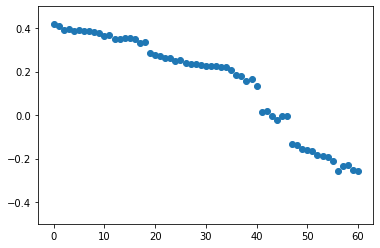

In [130]:
plt.plot(np.array(h[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


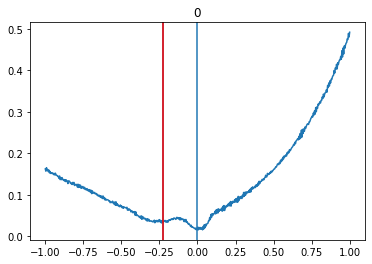

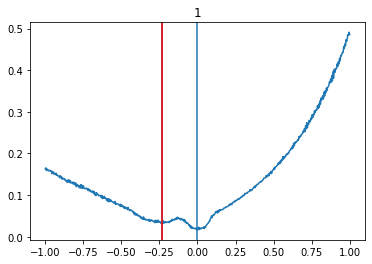

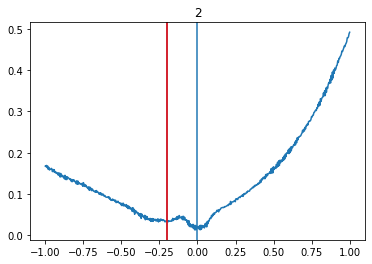

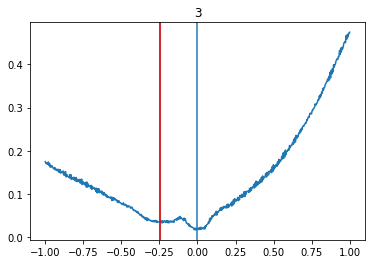

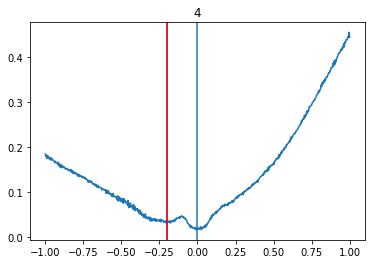

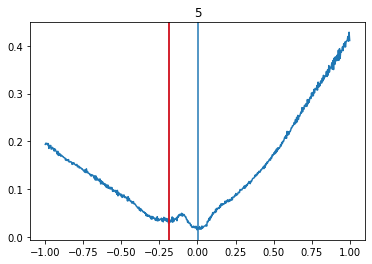

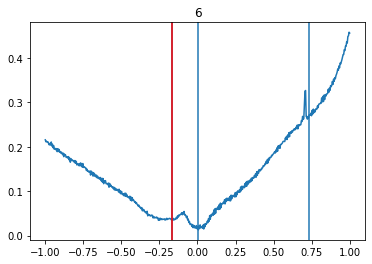

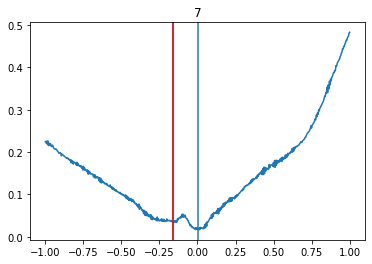

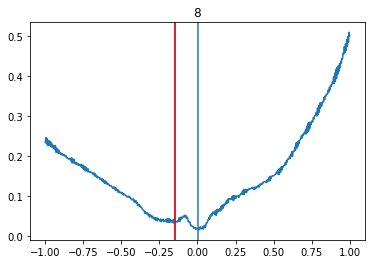

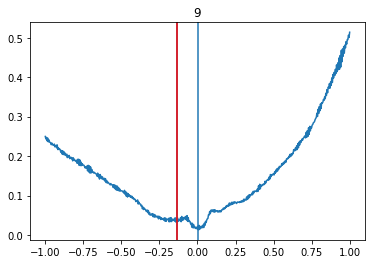

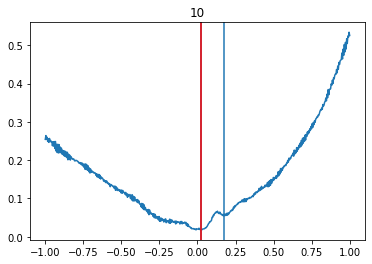

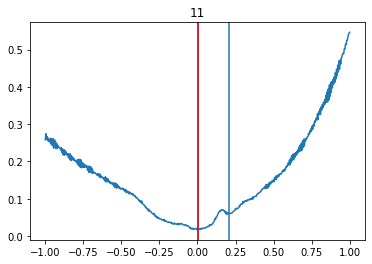

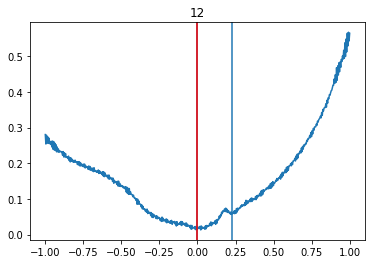

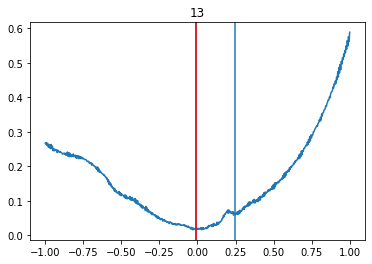

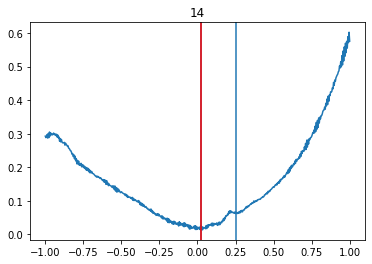

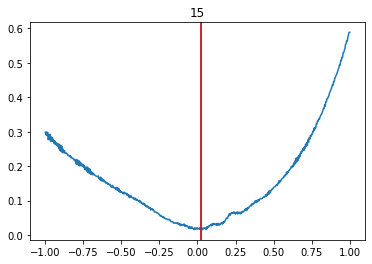

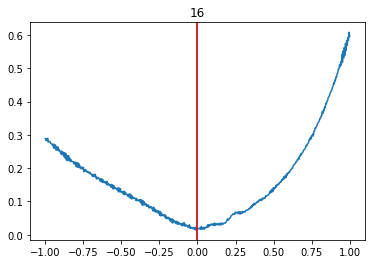

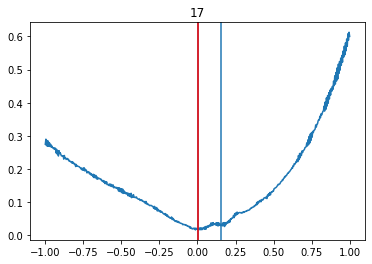

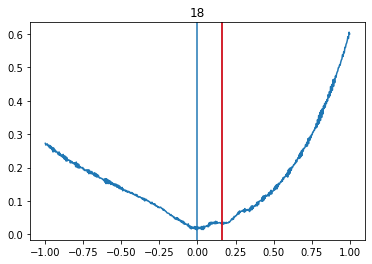

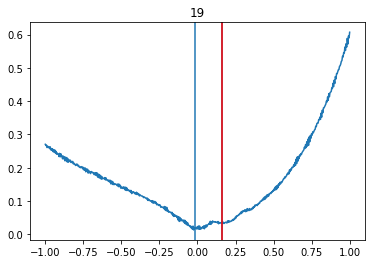

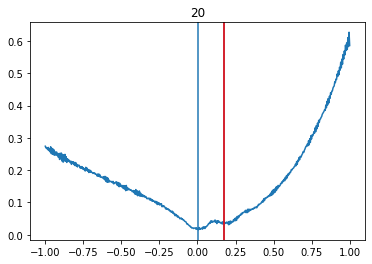

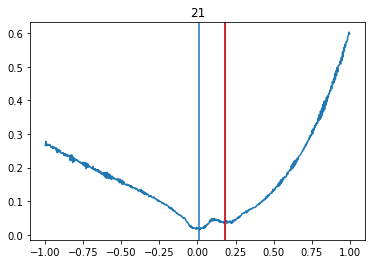

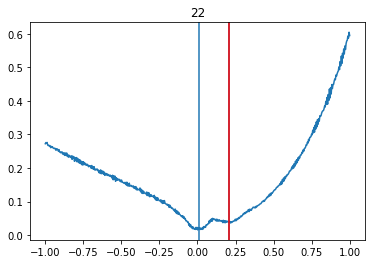

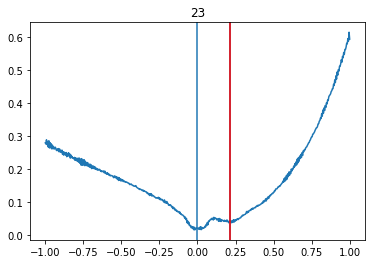

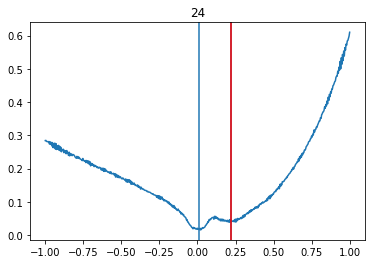

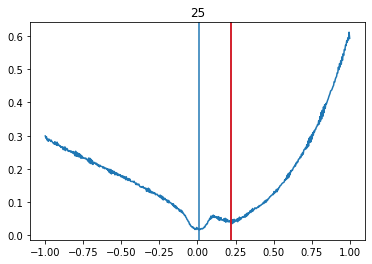

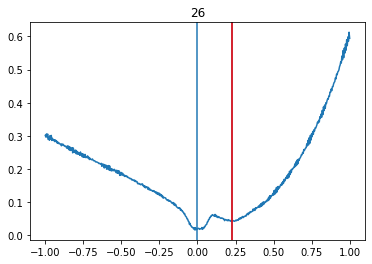

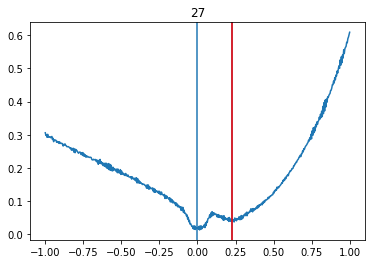

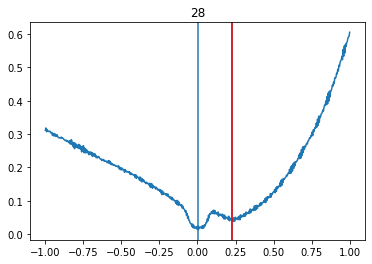

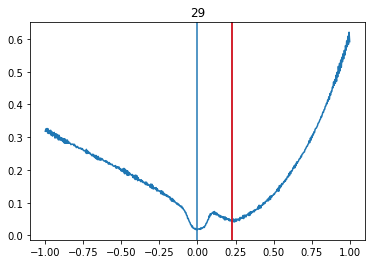

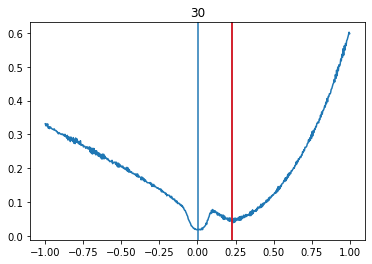

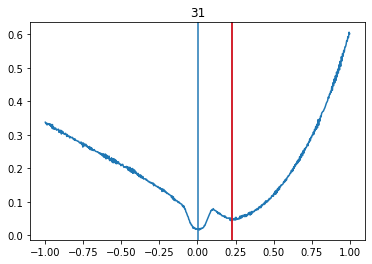

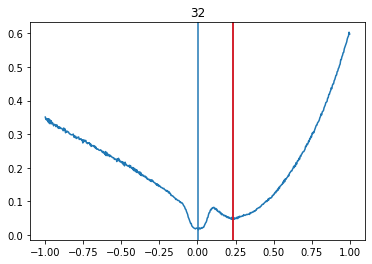

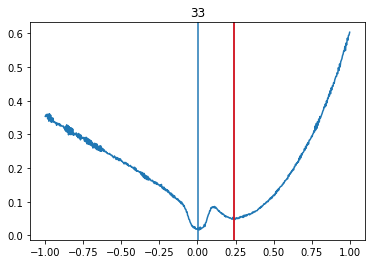

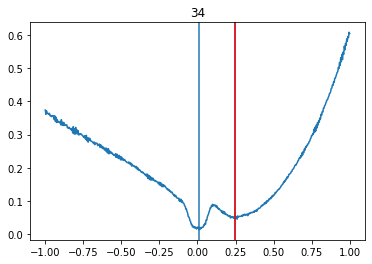

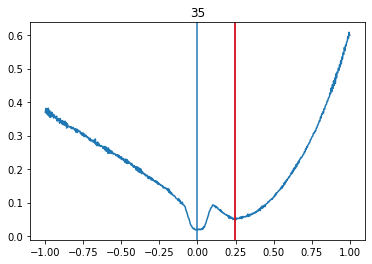

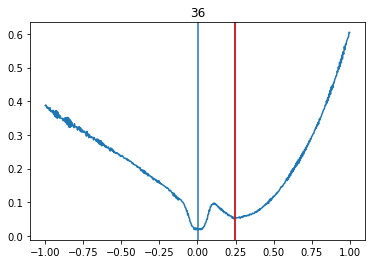

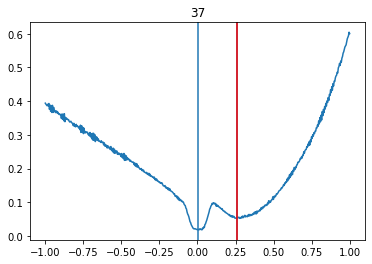

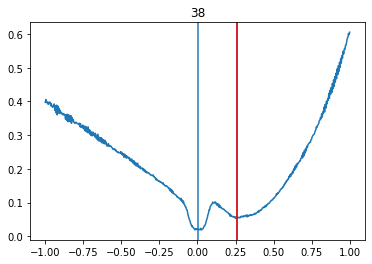

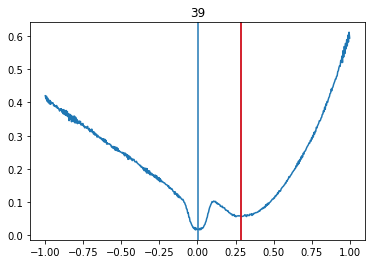

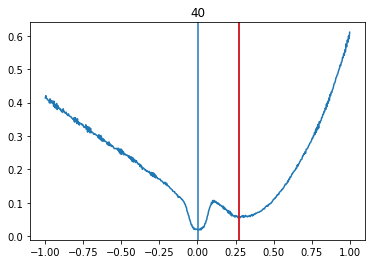

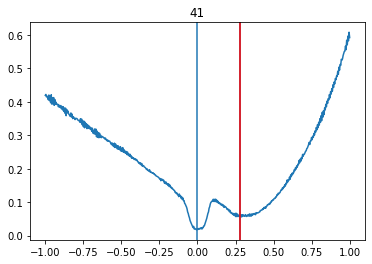

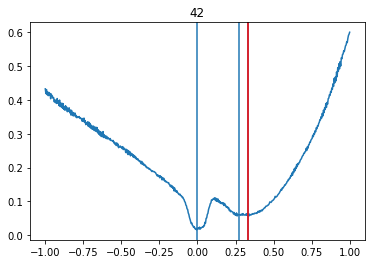

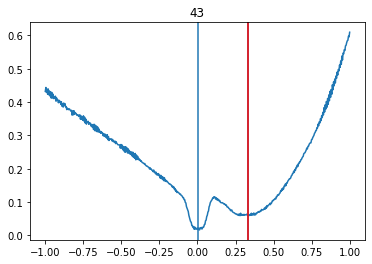

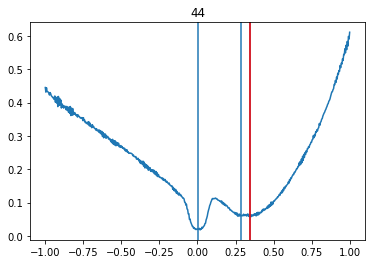

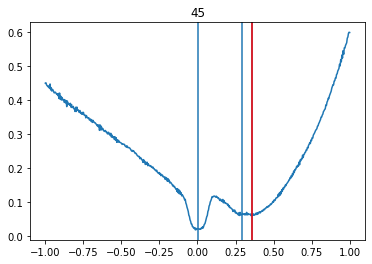

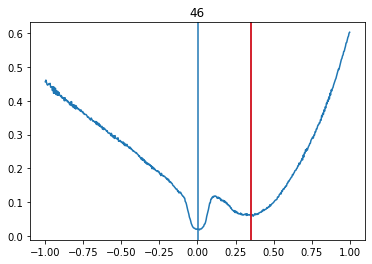

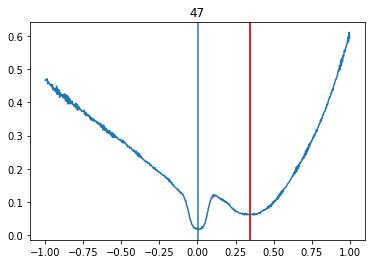

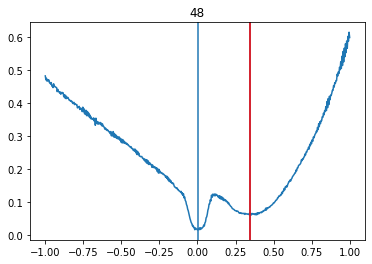

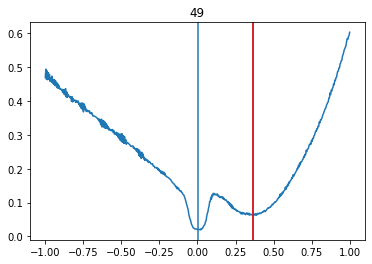

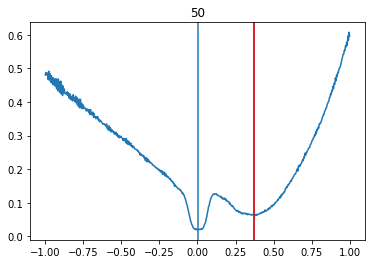

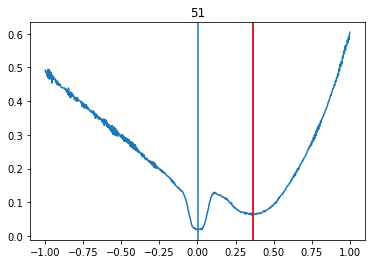

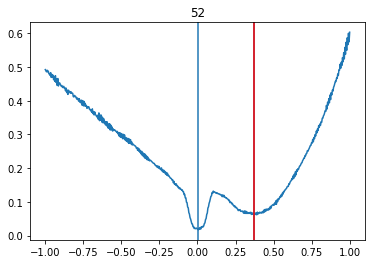

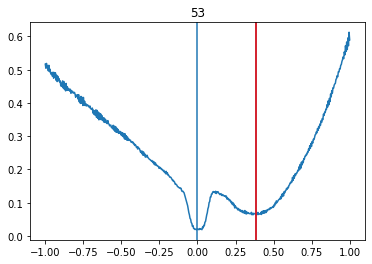

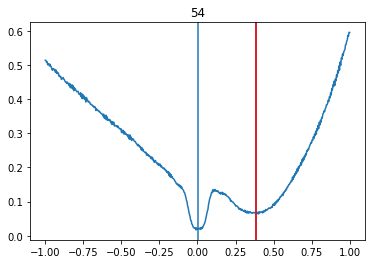

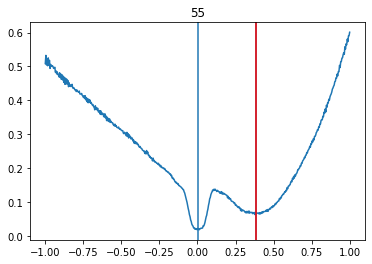

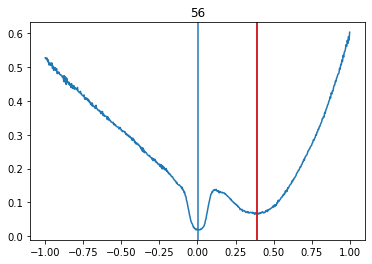

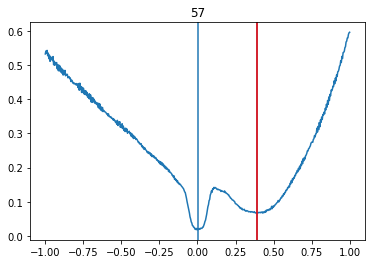

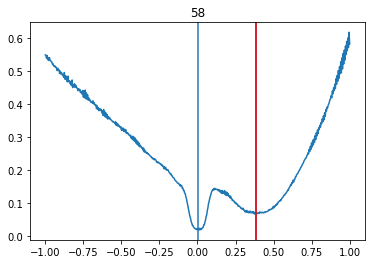

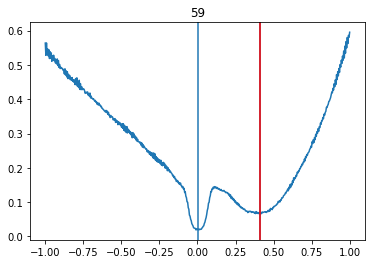

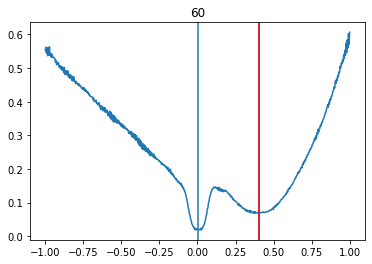

In [143]:
N_RANGE = (306, 367)
files = file_list(N_RANGE)
l = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 18:
        l.append(find_min(df, guess=-0.2, sig=3, dist=3, min_prom=6e-3, phon_correct=True, filenum=i))
    else:
        l.append(find_min(df, guess=0.5, sig=3, dist=3, min_prom=1e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

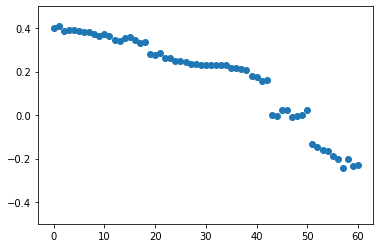

In [144]:
plt.plot(np.array(l[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


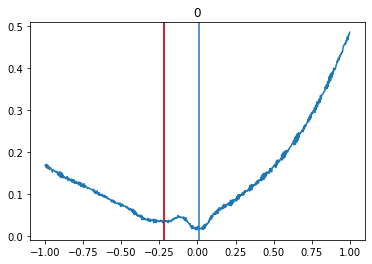

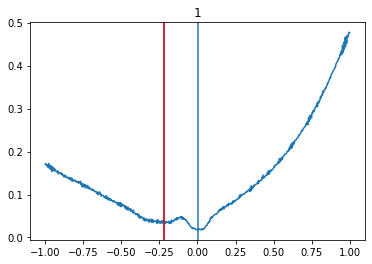

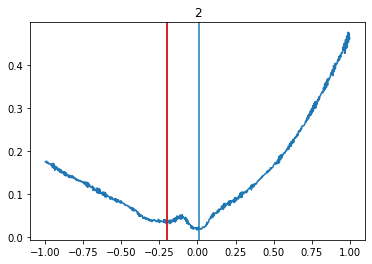

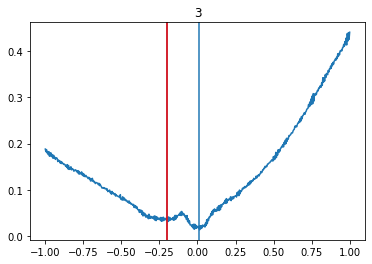

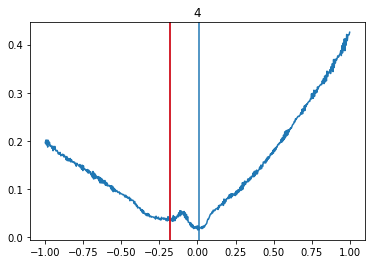

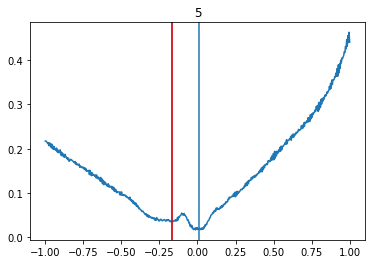

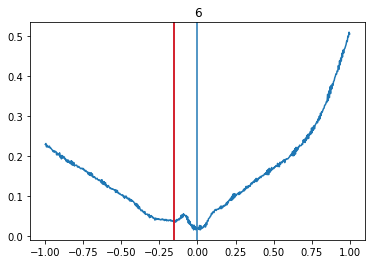

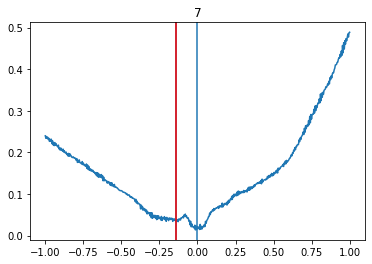

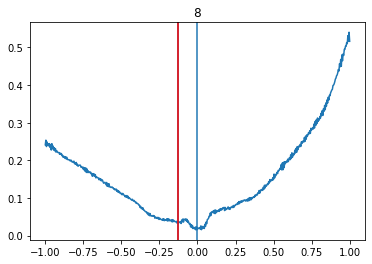

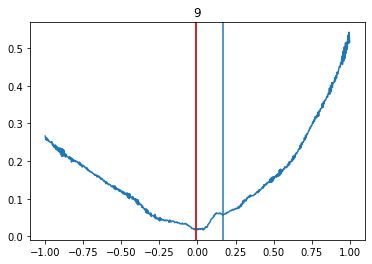

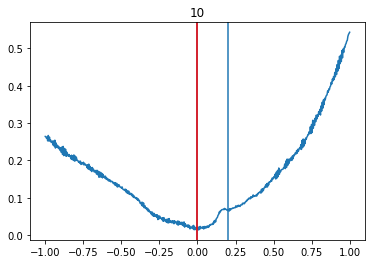

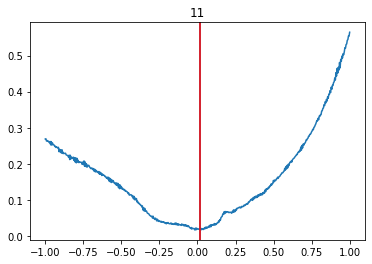

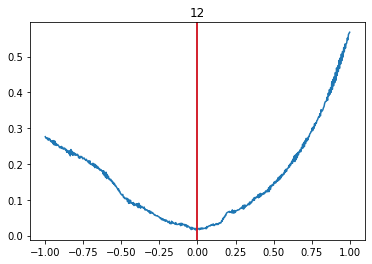

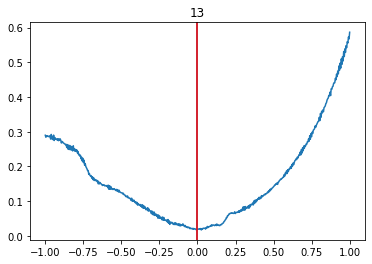

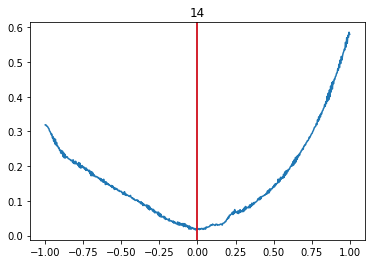

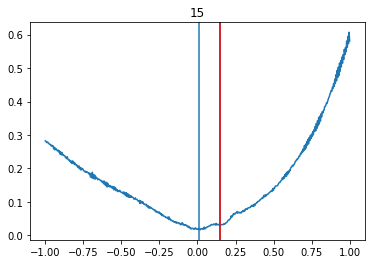

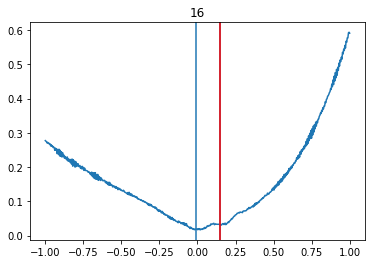

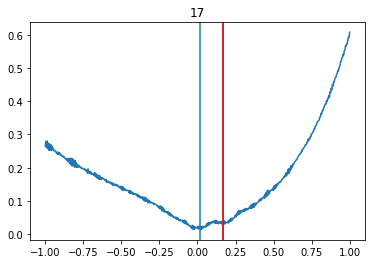

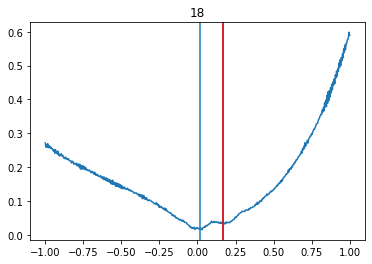

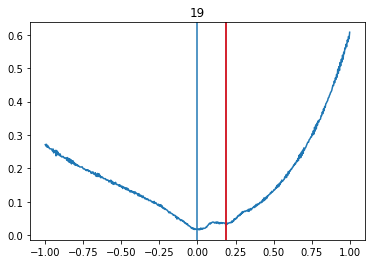

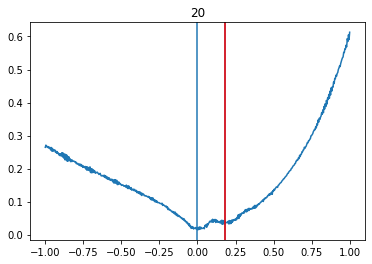

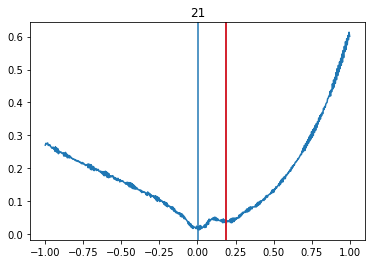

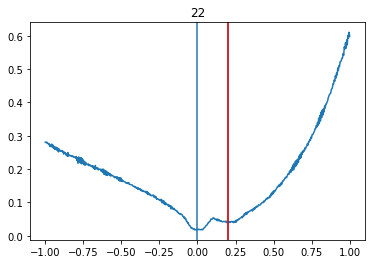

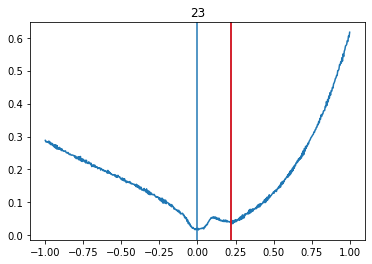

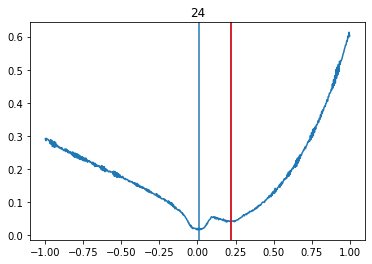

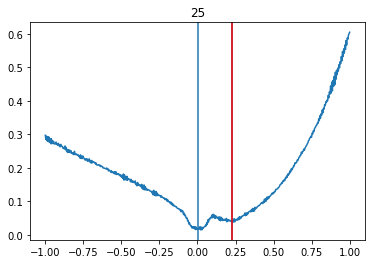

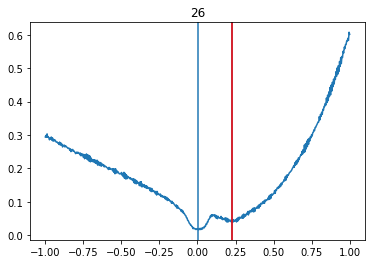

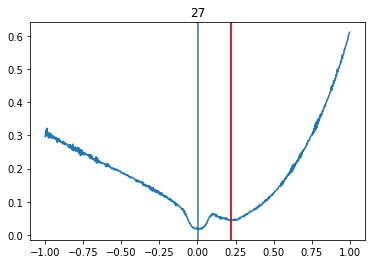

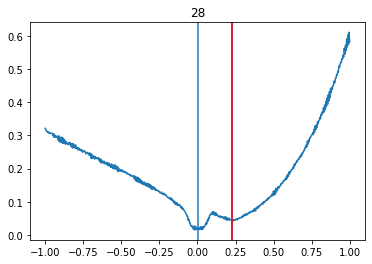

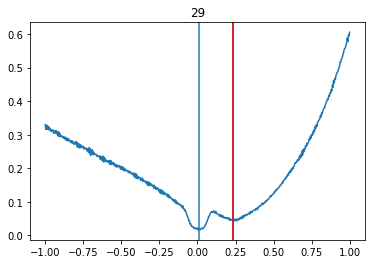

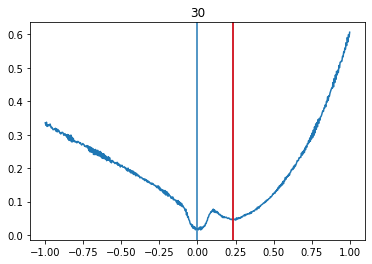

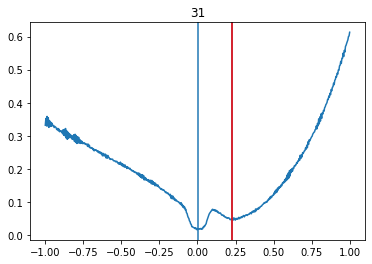

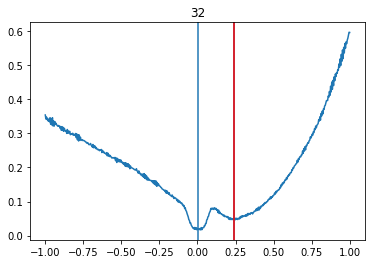

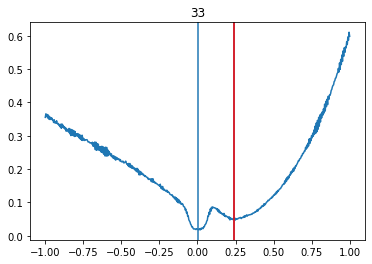

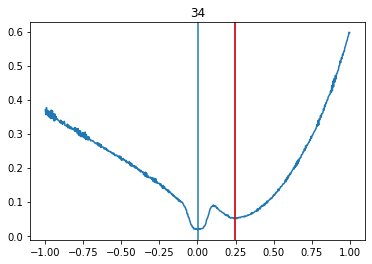

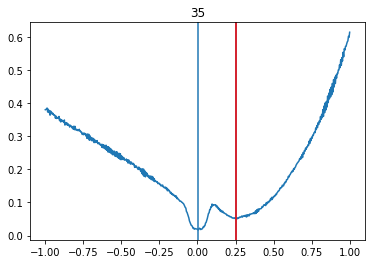

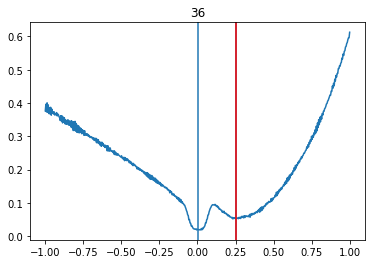

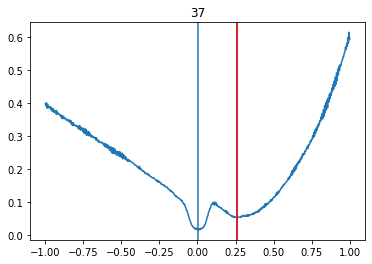

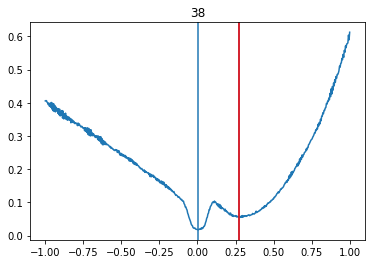

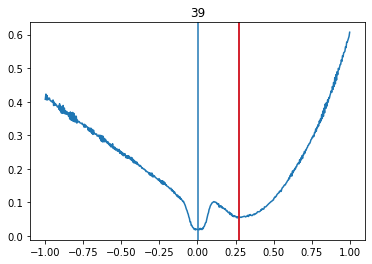

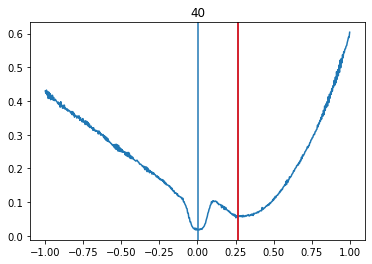

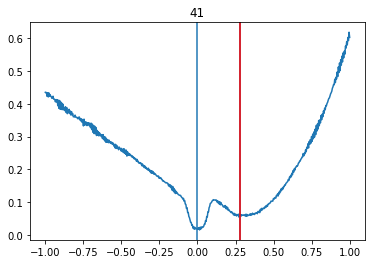

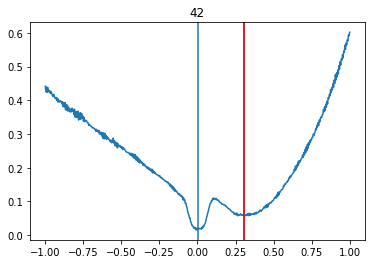

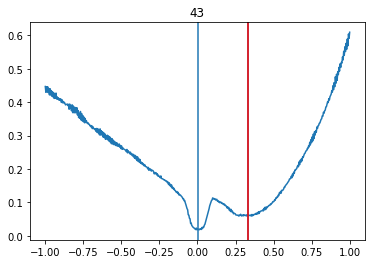

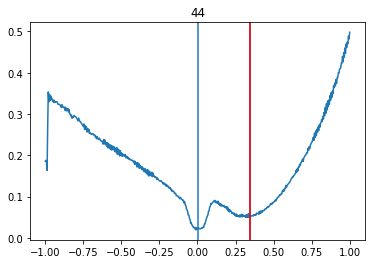

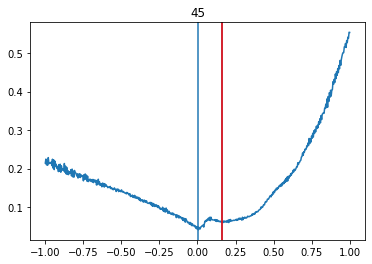

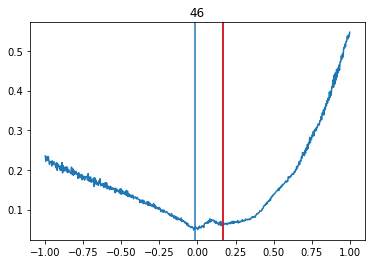

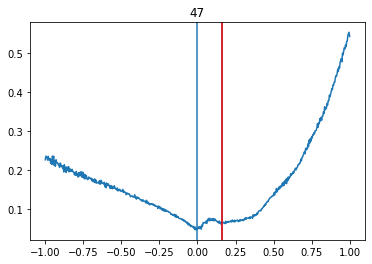

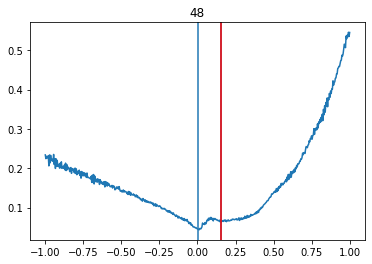

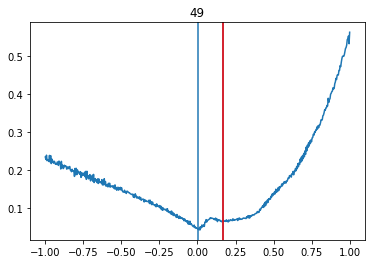

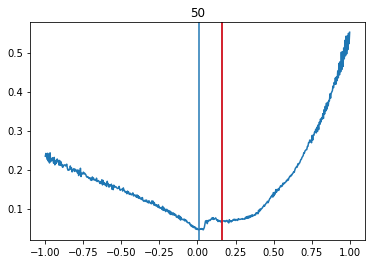

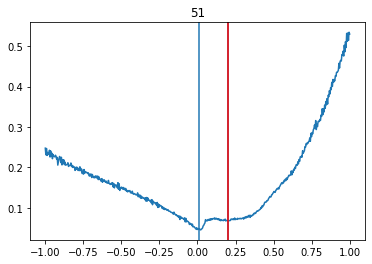

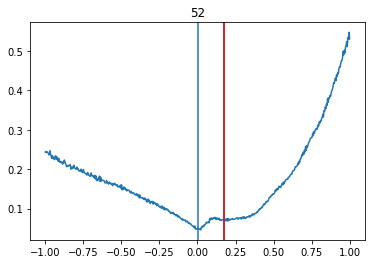

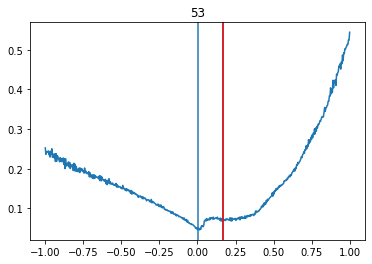

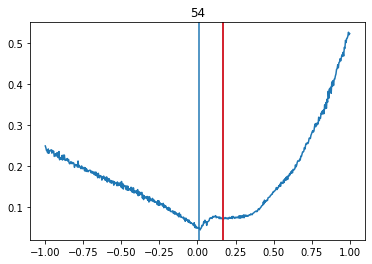

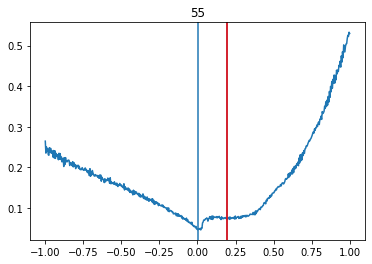

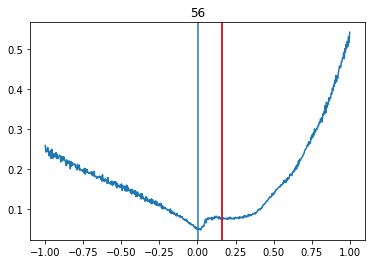

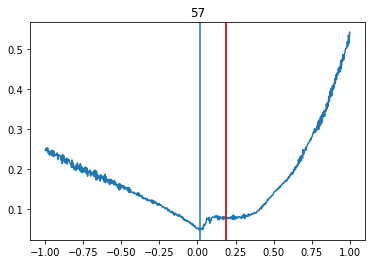

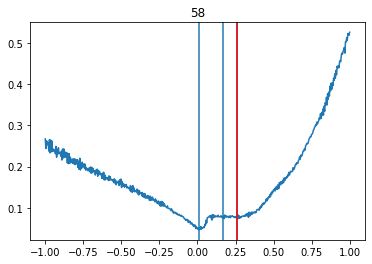

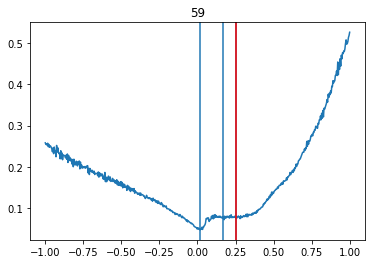

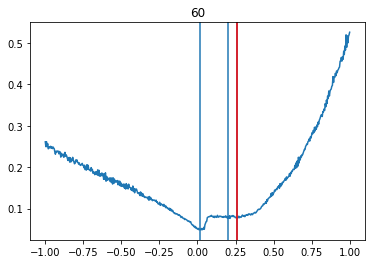

In [149]:
N_RANGE = (367, 428)
files = file_list(N_RANGE)
m = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 11:
        m.append(find_min(df, guess=-0.2, sig=3, dist=3, min_prom=6e-3, phon_correct=True, filenum=i))
    else:
        m.append(find_min(df, guess=0.5, sig=3, dist=3, min_prom=3e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

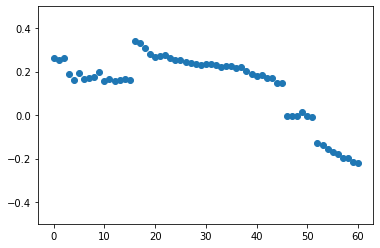

In [150]:
plt.plot(np.array(m[::-1]), 'o')
plt.ylim(-0.5, 0.5)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


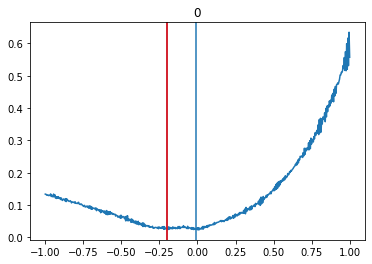

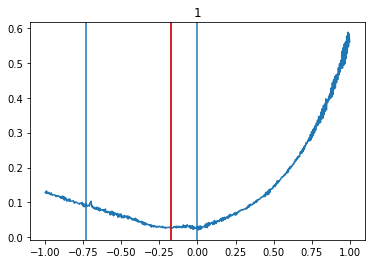

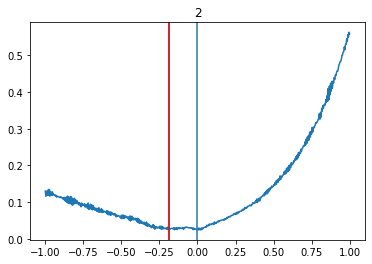

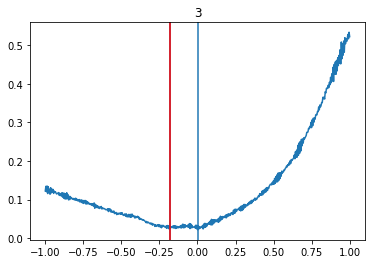

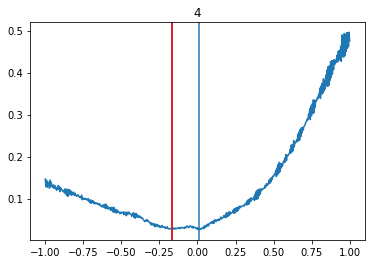

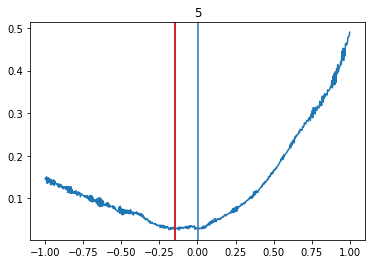

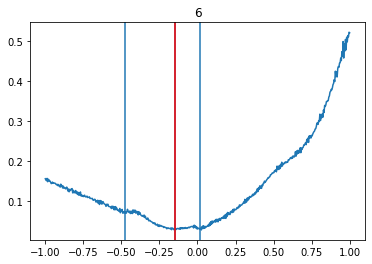

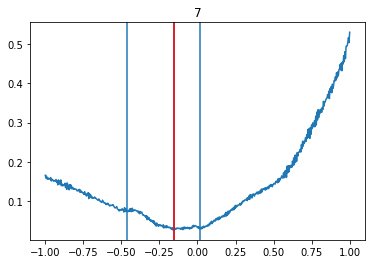

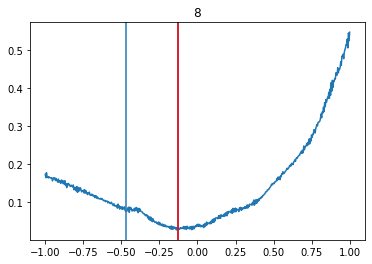

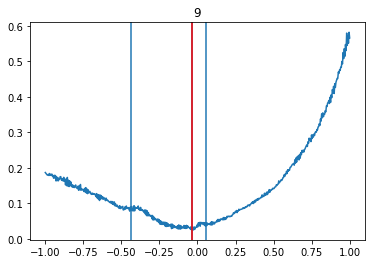

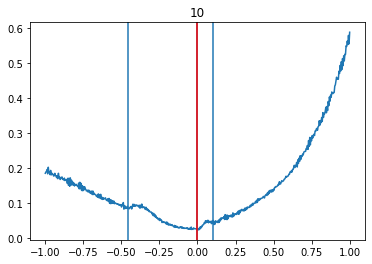

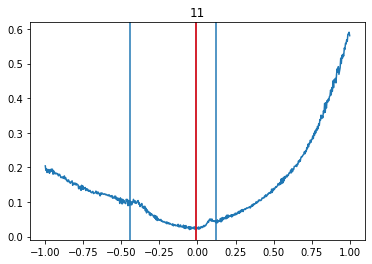

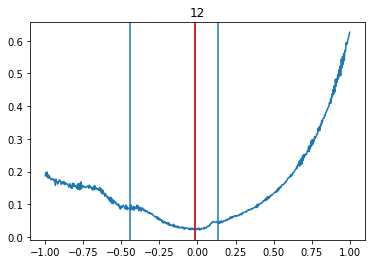

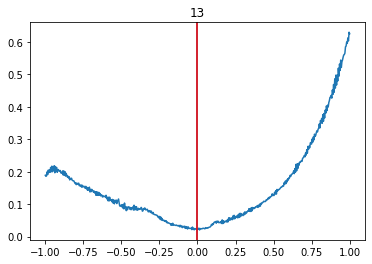

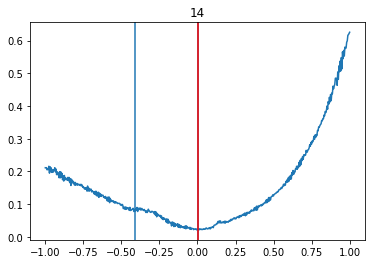

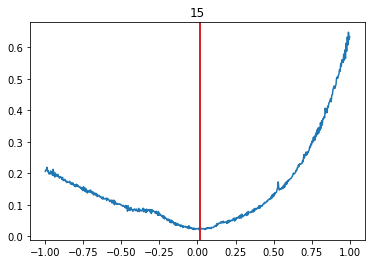

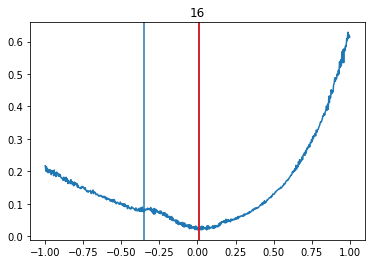

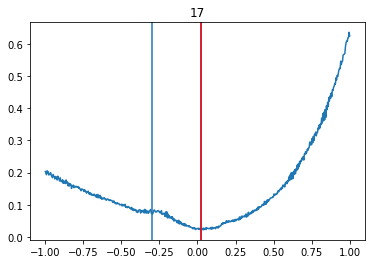

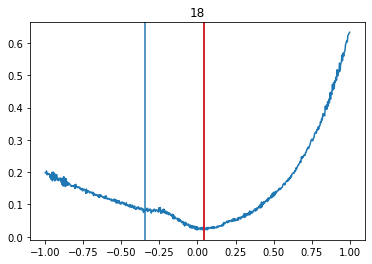

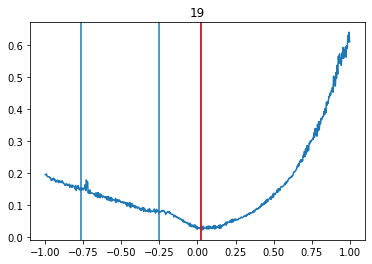

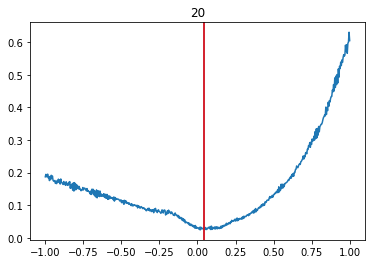

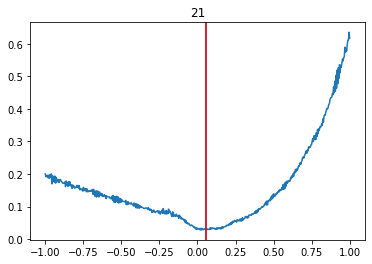

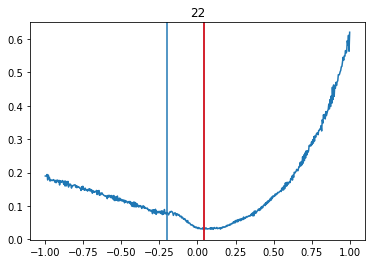

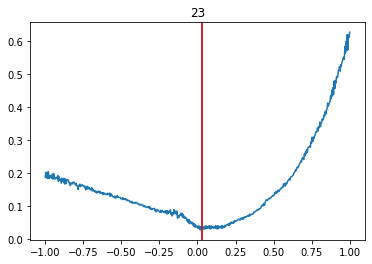

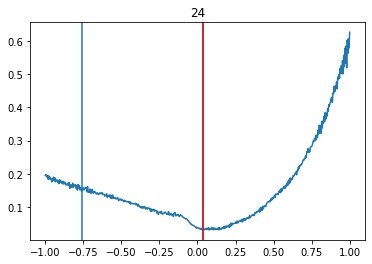

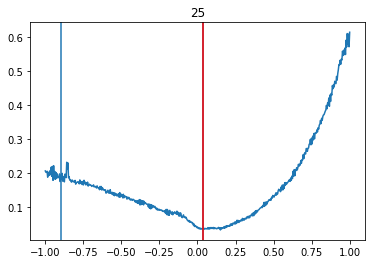

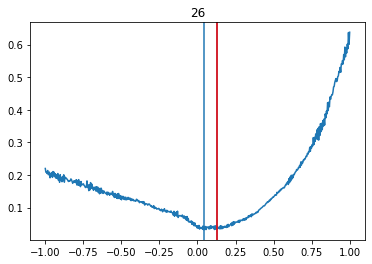

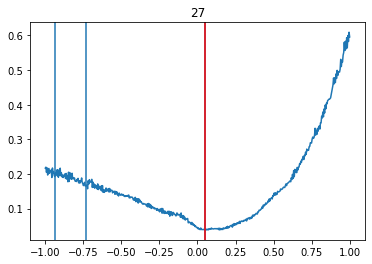

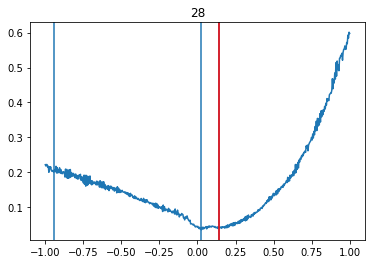

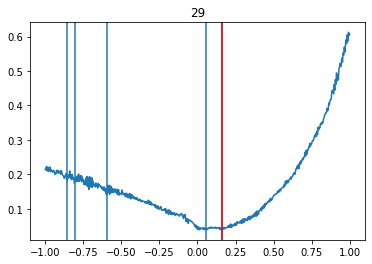

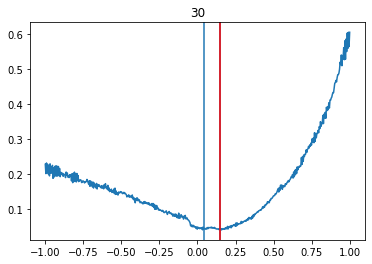

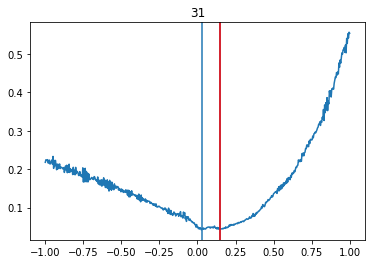

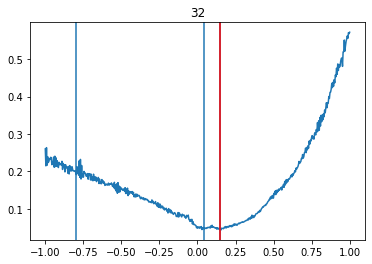

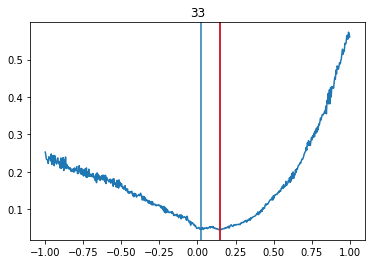

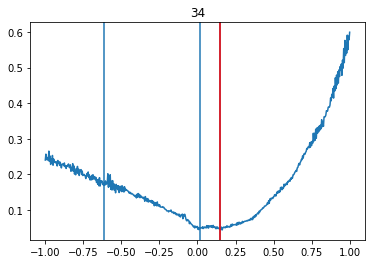

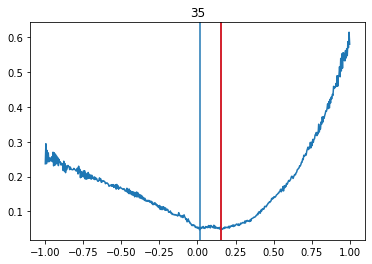

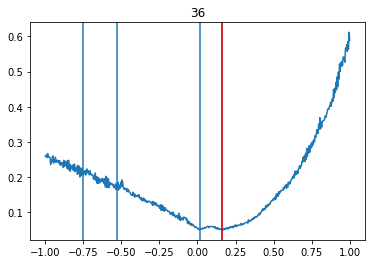

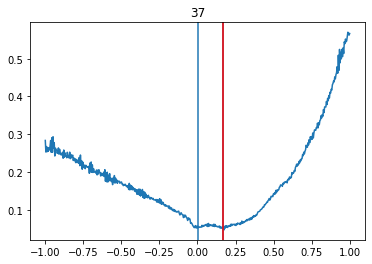

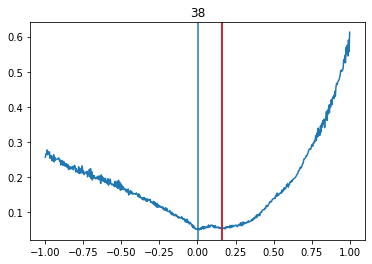

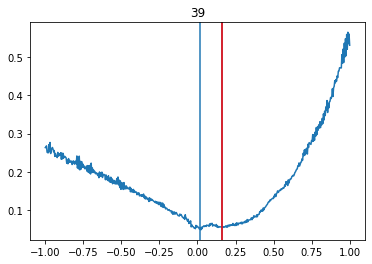

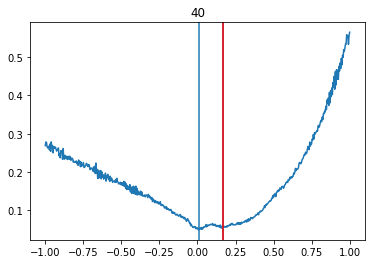

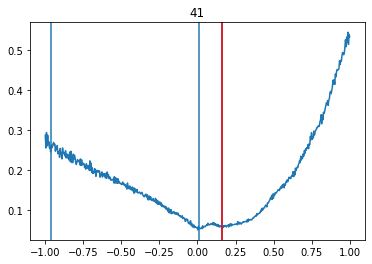

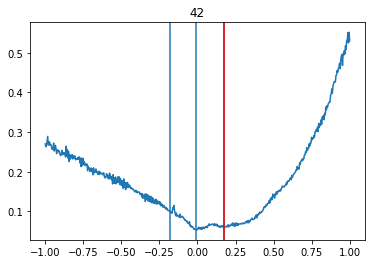

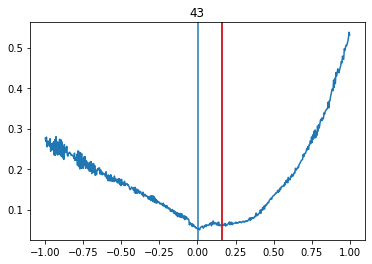

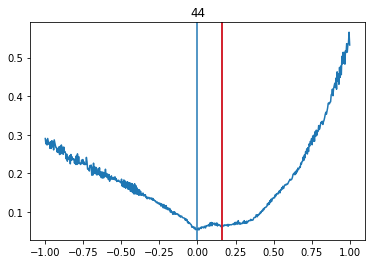

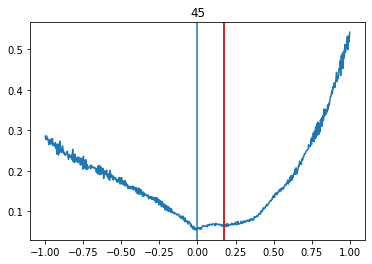

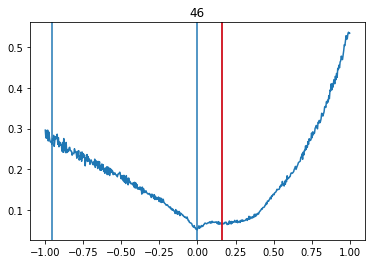

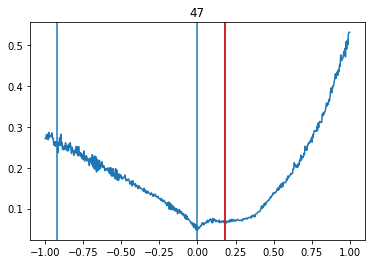

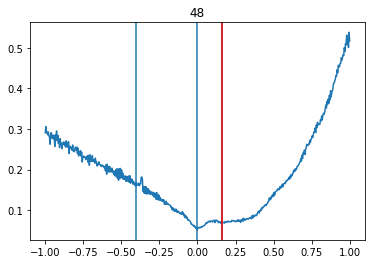

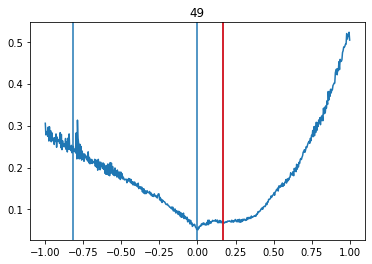

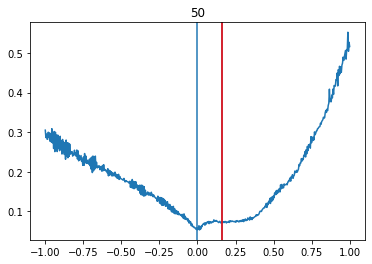

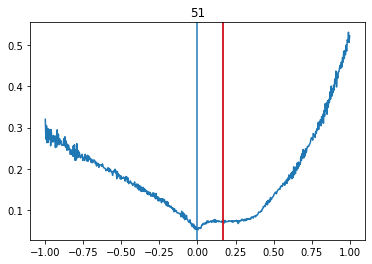

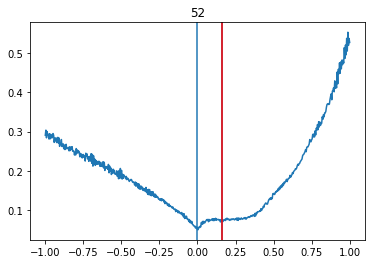

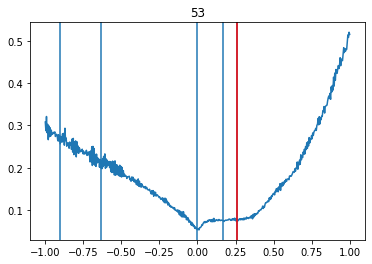

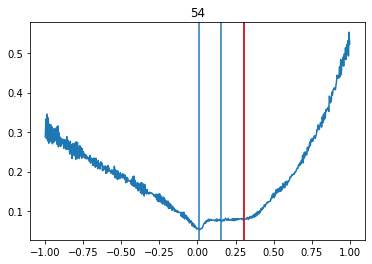

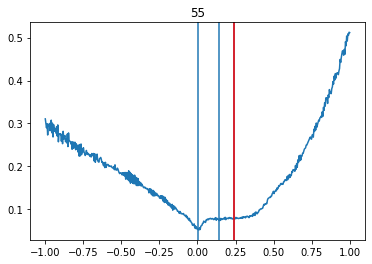

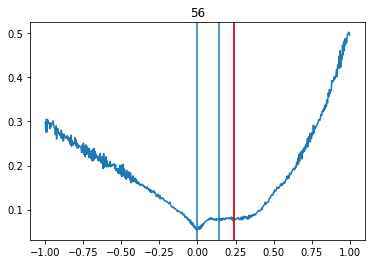

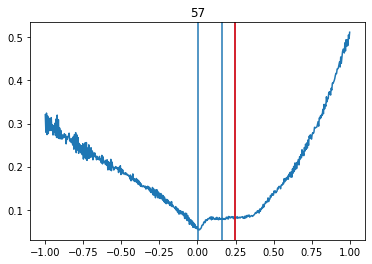

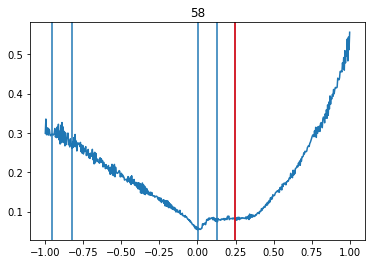

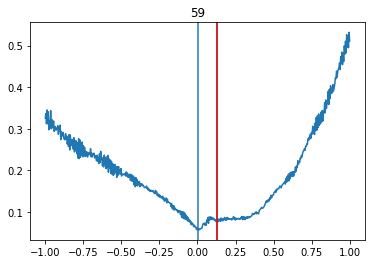

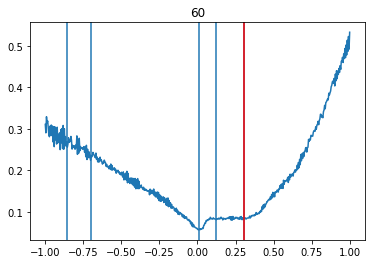

In [155]:
N_RANGE = (431, 492)
files = file_list(N_RANGE)
n = []
for i, f in enumerate(files):
    df = file2df(f)
    if i < 15:
        n.append(find_min(df, guess=-0.2, sig=3, dist=3, min_prom=6e-3, phon_correct=True, filenum=i))
    else:
        n.append(find_min(df, guess=0.5, sig=3, dist=3, min_prom=5e-3, phon_correct=True, filenum=i))
        

(-0.5, 0.5)

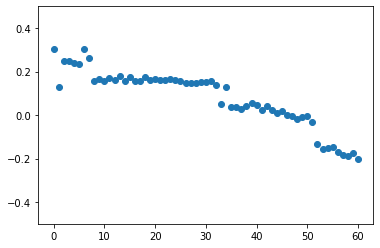

In [156]:
plt.plot(np.array(n[::-1]), 'o')
plt.ylim(-0.5, 0.5)

(-0.25, 0.4)

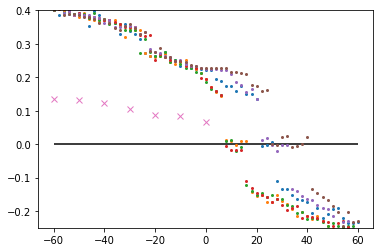

In [162]:

voltages = np.linspace(-60,60,61)
plt.plot(voltages,c[::-1], 'o', markersize=2)
plt.plot(voltages,d[::-1], 'o', markersize=2)
plt.plot(voltages,e[::-1], 'o', markersize=2)
plt.plot(voltages,g[::-1], 'o', markersize=2)
plt.plot(voltages,h[::-1], 'o', markersize=2)
plt.plot(voltages,l[::-1], 'o', markersize=2)
# plt.plot(voltages,m[::-1], 'o', markersize=2)
# plt.plot(voltages,n[::-1], 'o', markersize=2)
plt.plot(np.arange(-60, 10, 10), [0.1337, 0.1311, 0.1221, 0.1042, 0.0872, 0.0839, 0.0672], 'x')
plt.hlines(0,-60,60)
plt.ylim(-0.25,0.4)